# Real Estate Investment


## Business Problem

This study will focus on how time series modeling can determine the most profitable zipcodes for making real estate investments. The metric that we will be looking at will be the projected year-over-year ROI for a given zipcode. In our final analysis we will look at both the highest minimum ROIs that we can predict with 50% confidence as well as the highest minimum ROIs that we can predict with 97.5% confidence.

## Methods

Because the US housing market is subject to a number of exogenous macroeconomic factors, we attempt to control for these factors as much as possible. We will do this in two ways:

1. In calculating metrics such as ROI we will subtract the metric's value for the US as a whole from the metric's value for a given zip code. This has the effect of controlling for inflation as well as for overall trends in the US housing market. 
2. In training our model, we'll exclude data from before 2010, since, as we'll soon see, home prices exhibited drastically different patterns of change before that date. While it's possible that a new macroeconomic regime could alter patterns yet again, we want to abstract as much as possible from exogenous factors for the purpose of this study.

In order to narrow down the zipcodes to be studied we'll pick out the top five zip codes based on four metrics, calculated as averages over the last twelve months:
- Maximum median home value 
- Maximum Year-over-year ROI
- Maximum Increase in Year-over-year ROI
- Maximum Second Degree Increase in Year-over-year ROI

We'll select a time series model that best holds for all four categories of zipcode and use that model to predict year-over-year ROI for the next year for all zip codes in our data set. 

## Loading and Inspecting Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error

import itertools

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/zillow_data.csv')

In [3]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


## Checking for zipcodes with missing data

In [5]:
for column in data.columns:
    if data[column].isna().sum()>0:
        print(column)
        print(data[column].isna().sum())

Metro
1043
1996-04
1039
1996-05
1039
1996-06
1039
1996-07
1039
1996-08
1039
1996-09
1039
1996-10
1039
1996-11
1039
1996-12
1039
1997-01
1039
1997-02
1039
1997-03
1039
1997-04
1039
1997-05
1039
1997-06
1039
1997-07
1038
1997-08
1038
1997-09
1038
1997-10
1038
1997-11
1038
1997-12
1038
1998-01
1036
1998-02
1036
1998-03
1036
1998-04
1036
1998-05
1036
1998-06
1036
1998-07
1036
1998-08
1036
1998-09
1036
1998-10
1036
1998-11
1036
1998-12
1036
1999-01
1036
1999-02
1036
1999-03
1036
1999-04
1036
1999-05
1036
1999-06
1036
1999-07
1036
1999-08
1036
1999-09
1036
1999-10
1036
1999-11
1036
1999-12
1036
2000-01
1036
2000-02
1036
2000-03
1036
2000-04
1036
2000-05
1036
2000-06
1036
2000-07
1036
2000-08
1036
2000-09
1036
2000-10
1036
2000-11
1036
2000-12
1036
2001-01
1036
2001-02
1036
2001-03
1036
2001-04
1036
2001-05
1036
2001-06
1036
2001-07
1036
2001-08
1036
2001-09
1036
2001-10
1036
2001-11
1036
2001-12
1036
2002-01
1036
2002-02
1036
2002-03
1036
2002-04
1036
2002-05
1036
2002-06
1036
2002-07
1036
2

### Dropping zipcodes with missing data

In [6]:
data.dropna(subset=['1996-04'], inplace=True)

In [7]:
for column in data.columns:
    if data[column].isna().sum()>0:
        print(column)
        print(data[column].isna().sum())

Metro
789


## Define Functions for transforming data for time series analysis

In [8]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [9]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

## US Housing Market EDA

In [10]:
melted_data = melt_data(data)

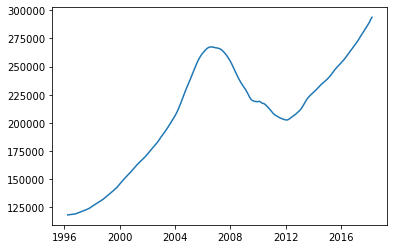

In [11]:
#plotting overall trend of US housing market.

plt.plot(melted_data)
plt.savefig('images/us_values.png')
plt.show()

Here we can see overall trends in the US housing market from 1996 to 2018. We can see the spike in home values beginning in the early 2000s followed by the fall in home prices caused by the mortgage crisis in 2007, followed by the recovery beginning in 2012. 

## Engineering Features: ROI, ROI 1st Difference, ROI 2nd Difference


We'll now define a new function that makes a time series data frame that includes information for ROI, 1st differencing of ROI and second differencing of ROI. This will allow us to pull out maximum values for each of these metrics in order to select zipcodes for further analysis.

In [12]:
def long_df(melted_data):
    
    '''
    Takes in a simple time series data frame and returns a new time series dataframe with columns for ROI, 
    1st Differencing of ROI and 2nd Differencing of ROI.
    '''
    
    melt_shift_1yr = melted_data.shift(periods=12)
    melt_shift_1yr.rename(columns={'value':'value - 1ya'}, inplace=True)
    melt_lag = pd.concat([melted_data, melt_shift_1yr], axis=1)
    melt_lag['ROI'] = (melt_lag['value']-melt_lag['value - 1ya'])/melt_lag['value - 1ya']
    melt_lag['ROI 1st Diff'] = melt_lag['ROI'].diff()
    melt_lag['ROI 2nd Diff'] = melt_lag['ROI 1st Diff'].diff()
    return melt_lag

In [13]:
us = long_df(melted_data)

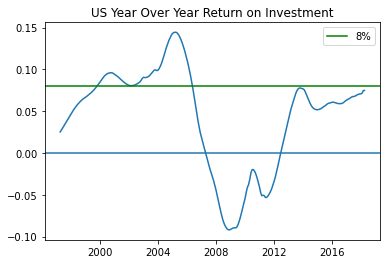

In [14]:
plt.plot(us['ROI'])
plt.axhline(y=0)
plt.axhline(y=0.08, color='green', label='8%')
plt.legend()
plt.title('US Year Over Year Return on Investment')
plt.savefig('images/us_ROI.png')
plt.show()

Here we see ROI reach unparalleled heights in the years before the crash, then declined from 2004 before reaching negative values between 2007 and 2012 and recovering beginning around 2013. However, even since the recovery, year over year ROI has stayed below 8%, which was the minimum ROI for the 2000-2007 period.

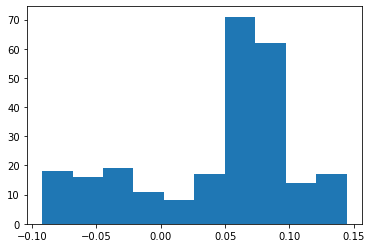

In [15]:
plt.hist(us['ROI'])
plt.show()

A histogram shows the highly non-normal distribution in ROI over the period in question, with the years of the recession skewing ROI strongly towards negative ranges.

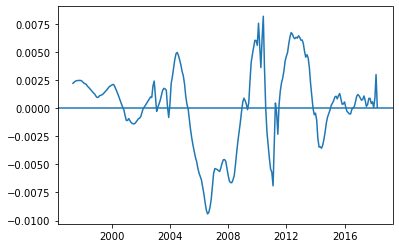

In [16]:
plt.plot(us['ROI 1st Diff'])
plt.axhline(y=0)
plt.savefig('images/us_1st_diff.png')
plt.show()

First differencing shows the increase in year over year ROI per month. Rather than showing overall profitability, this chart shows period of acceleration (positive values) and decleration (negative values) in the housing prices. The two big humps represent the recovery period and the lower variance after 2015 represents an overall stabilization of growth at the <8% level that we saw in the ROI chart.

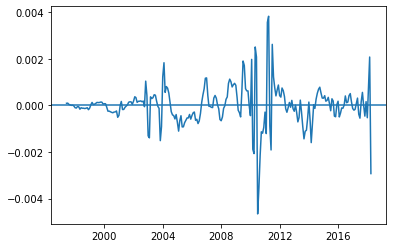

In [17]:
plt.plot(us['ROI 2nd Diff'])
plt.axhline(y=0)
plt.savefig('images/us_2nd_diff.png')
plt.show()

Seconding differencing shows the rate of acceleration and deceleration in the housing market. Peaks correspond to a transition from an decelerating pattern to a accelerating pattern whereas troughs correspond to a transition from a accelerating pattern to an decelerating pattern. 

## Selecting Zipcodes to Model

I'll be selecting zipcodes to model based on four criteria:

1. Highest absolute home values over the past 12 months
2. Highest average ROI over the past 12 months
3. Highest 1st Differencing of ROI over the past 12 months
4. Highest 2nd Differencing of ROI over the past 12 months

These four criteria represent four different ways of thinking about the goodness of an investment. The first is based simply on the current value of the investment. The second is based on how its value has increased in the past. The second is based on whether prices are accelerating. The third is based on whether acceleration is increasing. 

Because high asset prices can be the result of overvaluation and because rising asset prices can be the result of irrational exuberance, its possible that more complex metrics like first or second differencing might be better predictors of profitability than simpler metrics like mean ROI.

In [18]:
rolling_mean_value_list = []
rolling_mean_ROI_list = []
rolling_mean_1st_diff_list = []
rolling_mean_2nd_diff_list = []



# Generate melted data frames for each zipcode, subtracting values for the US as a whole to detrend data for each
# statistic. Then find final value of rolling mean for each each statistic. 


for zipcode in data['RegionName'].values:
    melted = melt_data(data[data['RegionName']==zipcode])
    long_zip_df = long_df(melted)
    
    zip_minus_us = long_zip_df-us
    
    mean_value = zip_minus_us['value'].rolling(12).mean()[-1]    
    mean_ROI = zip_minus_us['ROI'].rolling(12).mean()[-1]
    mean_ROI_1st_diff = zip_minus_us['ROI 1st Diff'].rolling(12).mean()[-1]
    mean_ROI_2nd_diff = zip_minus_us['ROI 2nd Diff'].rolling(12).mean()[-1]

    rolling_mean_value_list.append(mean_value)
    rolling_mean_ROI_list.append(mean_ROI)
    rolling_mean_1st_diff_list.append(mean_ROI_1st_diff)
    rolling_mean_2nd_diff_list.append(mean_ROI_2nd_diff)

In [19]:
data_with_metrics = data.copy()

data_with_metrics['Mean Value'] = rolling_mean_value_list
data_with_metrics['Mean ROI'] = rolling_mean_ROI_list
data_with_metrics['Mean ROI 1st Diff'] = rolling_mean_1st_diff_list
data_with_metrics['Mean ROI 2nd Diff'] = rolling_mean_2nd_diff_list

In [20]:
top_5_values = data_with_metrics.sort_values(by='Mean Value', ascending=False).head()
top_5_values

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Mean Value,Mean ROI,Mean ROI 1st Diff,Mean ROI 2nd Diff
21,61703,10128,New York,NY,New York,New York,22,3676700.0,3704200.0,3729600.0,...,7371400,7342700,7353300,7350300,7363000,7386600,7.092907e+06,-0.043553,0.000560,-0.001297
10237,97518,94027,Atherton,CA,San Francisco,San Mateo,10238,1179200.0,1184300.0,1189700.0,...,6429100,6581800,6705000,6764600,6788400,6796500,6.138891e+06,0.053040,0.004962,-0.001975
4816,96086,90210,Beverly Hills,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,4817,1015400.0,1016900.0,1018400.0,...,5574100,5661000,5738200,5816100,5907800,5956700,5.293366e+06,0.027659,0.001730,0.000450
4723,72636,33480,Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,4724,958400.0,958100.0,957900.0,...,4588200,4609000,4626500,4661200,4692300,4686200,4.296349e+06,0.005020,-0.003774,-0.000299
2026,97577,94123,San Francisco,CA,San Francisco,San Francisco,2027,849100.0,859000.0,868800.0,...,4596300,4579000,4582000,4597600,4640200,4682300,4.292207e+06,-0.007053,-0.001610,-0.002146


In [21]:
top_5_ROI = data_with_metrics.sort_values(by='Mean ROI', ascending=False).head()
top_5_ROI

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Mean Value,Mean ROI,Mean ROI 1st Diff,Mean ROI 2nd Diff
8079,72126,32640,Hawthorne,FL,Palatka,Putnam,8080,47200.0,47600.0,48100.0,...,118800,117700,117500,117800,117300,116700,-170467.544212,0.290014,-0.012746,-0.005697
3229,71796,32117,Holly Hill,FL,Daytona Beach,Volusia,3230,54000.0,53900.0,53800.0,...,111100,114100,116000,117900,120200,121500,-175792.544212,0.286975,0.006397,-0.003826
4554,72830,33805,Lakeland,FL,Lakeland,Polk,4555,41900.0,41900.0,42000.0,...,94400,97000,99000,100400,101600,102500,-191375.877546,0.280185,-0.002008,-0.006833
12452,60595,7088,Union,NJ,New York,Union,12453,107900.0,108600.0,109400.0,...,243100,245700,250700,252900,251600,249500,-52425.877546,0.277191,0.007195,-0.005936
4293,87104,66104,Kansas City,KS,Kansas City,Wyandotte,4294,41300.0,41200.0,41200.0,...,54200,55700,55700,55900,57800,59800,-231734.210879,0.269568,-0.006861,-0.002895


In [22]:
top_5_ROI_1st_Diff=data_with_metrics.sort_values(by='Mean ROI 1st Diff', ascending=False).head()
top_5_ROI_1st_Diff

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Mean Value,Mean ROI,Mean ROI 1st Diff,Mean ROI 2nd Diff
4211,60610,7106,Newark,NJ,New York,Essex,4212,91400.0,91300.0,91200.0,...,164500,169700,175200,180900,185300,186700,-124292.544212,0.147019,0.056720,-0.001652
3285,66014,19601,Reading,PA,Reading,Berks,3286,38400.0,38200.0,37900.0,...,48300,48500,48500,49100,51200,52900,-237934.210879,0.216010,0.043492,-0.004467
2725,71469,31204,Macon,GA,Macon,Bibb,2726,63200.0,63500.0,63900.0,...,49200,51200,52700,54400,57200,59300,-235384.210879,-0.072996,0.037284,0.010811
9897,60663,7422,Highland Lake,NJ,New York,Sussex,9898,120400.0,120400.0,120400.0,...,154600,159600,164500,167900,169100,169200,-131592.544212,0.062671,0.034745,-0.002244
605,66828,21218,Baltimore,MD,Baltimore,Baltimore City,606,44700.0,44700.0,44700.0,...,81100,84800,88200,91800,96400,99900,-201725.877546,-0.015051,0.034555,0.009808


In [23]:
top_5_ROI_2nd_Diff=data_with_metrics.sort_values(by='Mean ROI 2nd Diff', ascending=False).head()
top_5_ROI_2nd_Diff

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Mean Value,Mean ROI,Mean ROI 1st Diff,Mean ROI 2nd Diff
10232,90230,74016,Chelsea,OK,Tulsa,Rogers,10233,30100.0,30300.0,30400.0,...,73900,76800,79600,82600,86600,89600,-207234.210879,-0.119843,0.011883,0.015343
4381,79244,48503,Flint,MI,Flint,Genesee,4382,47100.0,47200.0,47400.0,...,21000,20800,20500,20800,21700,22800,-264292.544212,0.033233,0.026680,0.014735
10021,84735,60954,Momence,IL,Kankakee,Kankakee,10022,78400.0,78300.0,78000.0,...,82200,82700,83800,85900,89400,92500,-203842.544212,-0.001019,0.034296,0.010939
11987,74134,37051,Cunningham,TN,Clarksville,Montgomery,11988,38000.0,38400.0,38900.0,...,113400,114900,115300,117100,123000,129200,-168817.544212,-0.099980,0.005583,0.010902
2725,71469,31204,Macon,GA,Macon,Bibb,2726,63200.0,63500.0,63900.0,...,49200,51200,52700,54400,57200,59300,-235384.210879,-0.072996,0.037284,0.010811


In [24]:
#Creating a list of top five dataframes

dfs = [top_5_values, top_5_ROI, top_5_ROI_1st_Diff, top_5_ROI_2nd_Diff]

#Creating a dictionary of zip codes and city names for the top row in each dataframe

zip_dict_1 = {df.iloc[0, 1]: df.iloc[0, 2] for df in dfs}

## Function to Display Metrics by Zipcode

In [25]:
def plot_zip(zipcode_df, metric):
    
    '''
    Takes in time series dataframe for a given zipcode and returns plot for a given metric as well as a plot 
    for the a detrended metric in which the metric for the US as a whole is subtracted from the metric for the 
    given zipcode.
    '''
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    ax1.plot(zipcode_df[metric], label='zipcode')
    ax1.plot(us[metric], label='us', color='red')
    ax1.set_xlabel('year')
    ax1.set_ylabel(metric)
    ax1.set_title(metric)
    
    relative = zipcode_df[metric]-us[metric]
    
    ax2.plot(relative)
    ax2.set_xlabel('year')
    ax2.set_ylabel(metric)
    ax2.set_title(f'{metric} relative to US')
    
    #plot rolling means
    ax1.plot(zipcode_df[metric].rolling(12).mean(), color='orange', label='12 month rolling mean')
    ax2.plot(relative.rolling(12).mean(), color='orange')

        
    #plot horizontal lines
    ax1.axhline(y=0)
    ax2.axhline(y=0)
        
    ax1.legend()

In [26]:
#create time series dataframe for the 5 zipcodes that we will be plotting.

melted_dfs_dict_1 = {city_name: long_df(melt_data(data[data['RegionName']==zipcode])) for zipcode, city_name in zip_dict_1.items()}

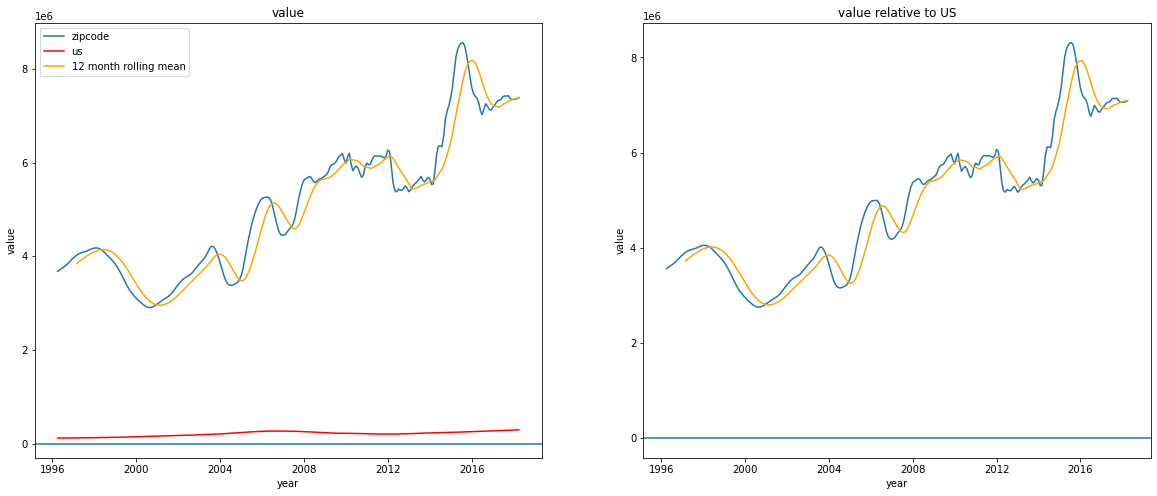

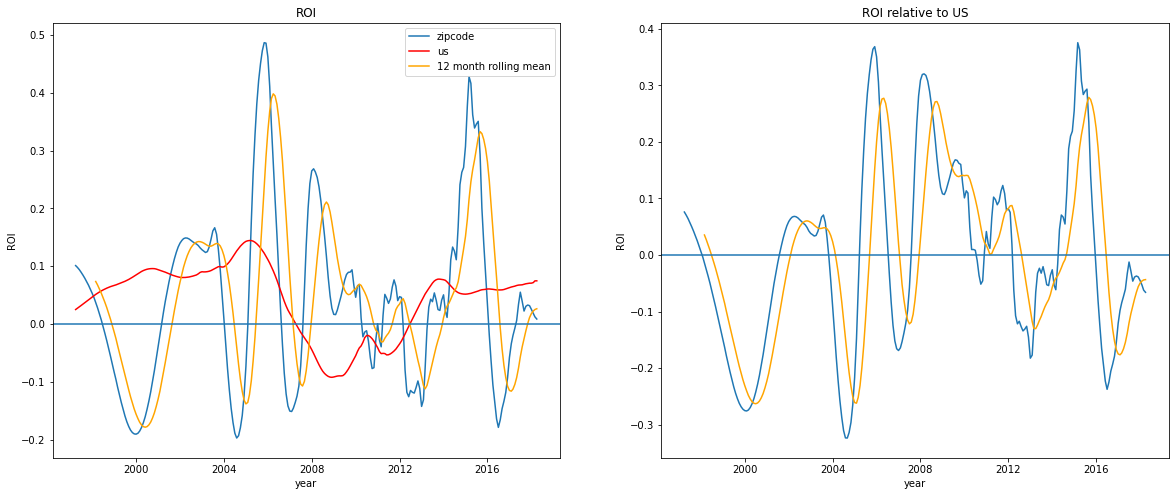

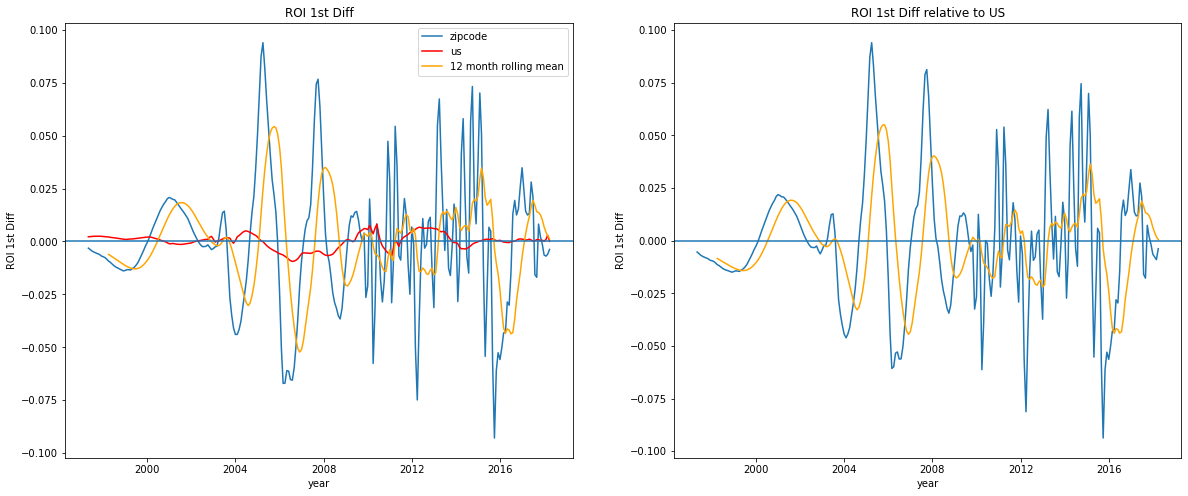

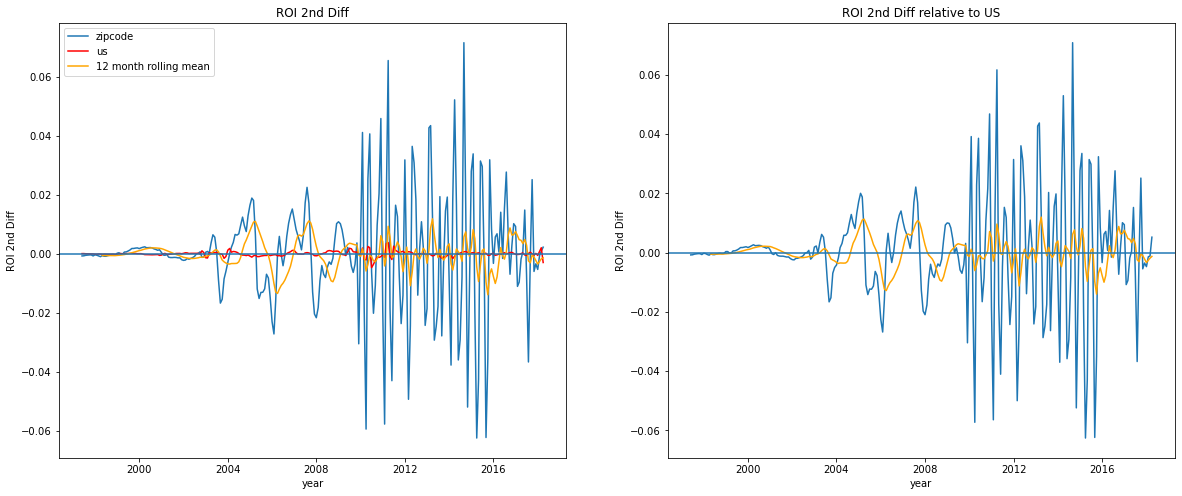

In [27]:
for column in melted_dfs_dict_1['New York'].columns.drop('value - 1ya'):
    plot_zip(melted_dfs_dict_1['New York'], column)
plt.savefig('images/new_york_plots.png')

Since we selected it for being the most expensive zipcode, the value plot shows the extent to which Manhattan real estate prices are far above the US average. Manhattan ROIs are often uncorrelated with ROI for the real estate market as a whole, with a decline in returns during the bubble years and a massive and early recovery after a brief plummit at the start of the mortgage crisis. 

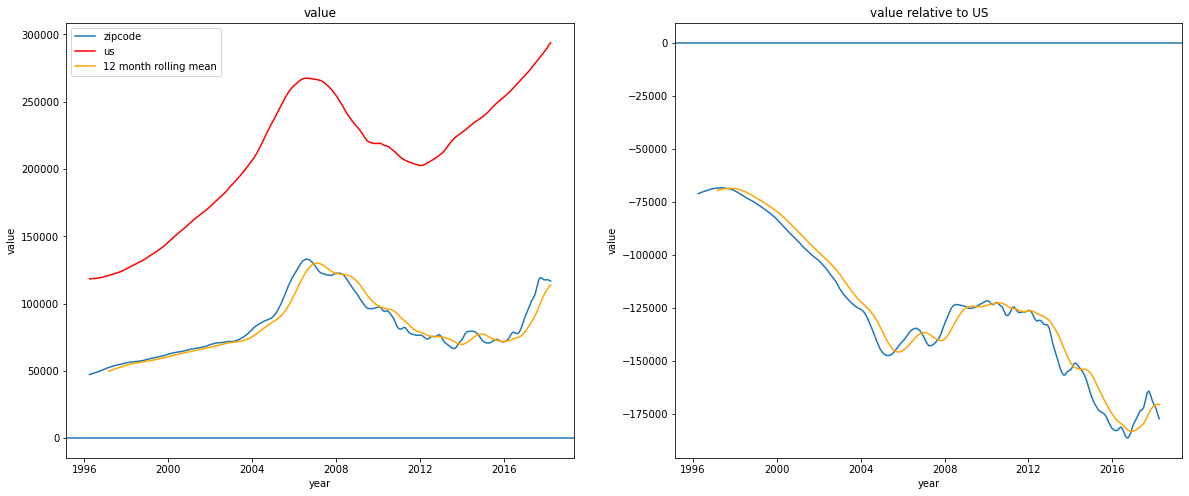

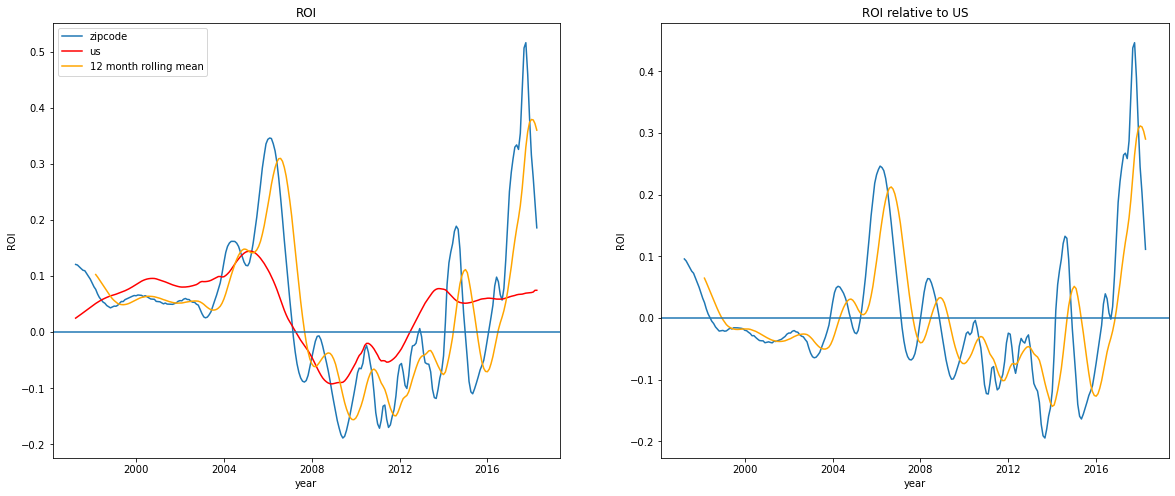

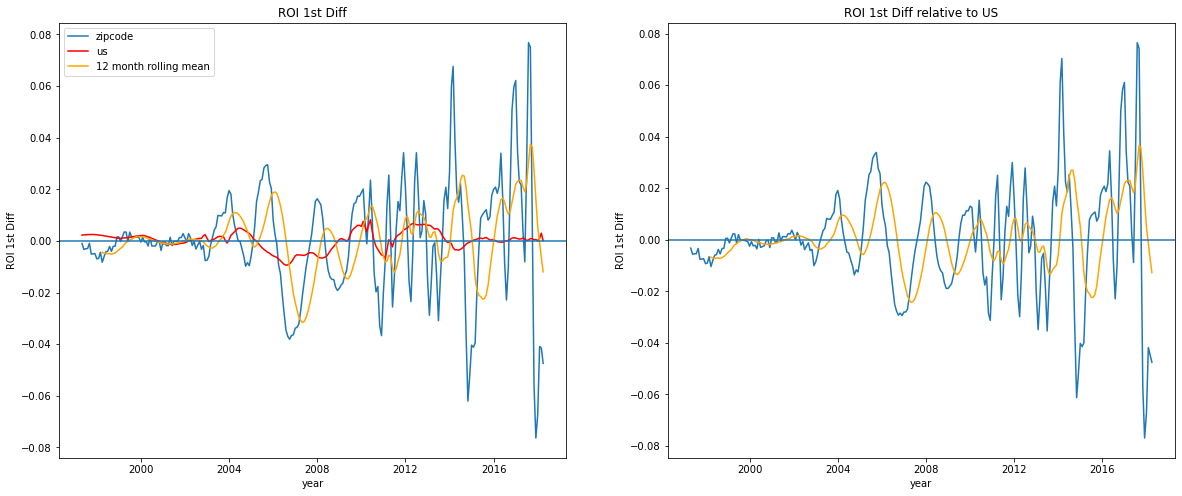

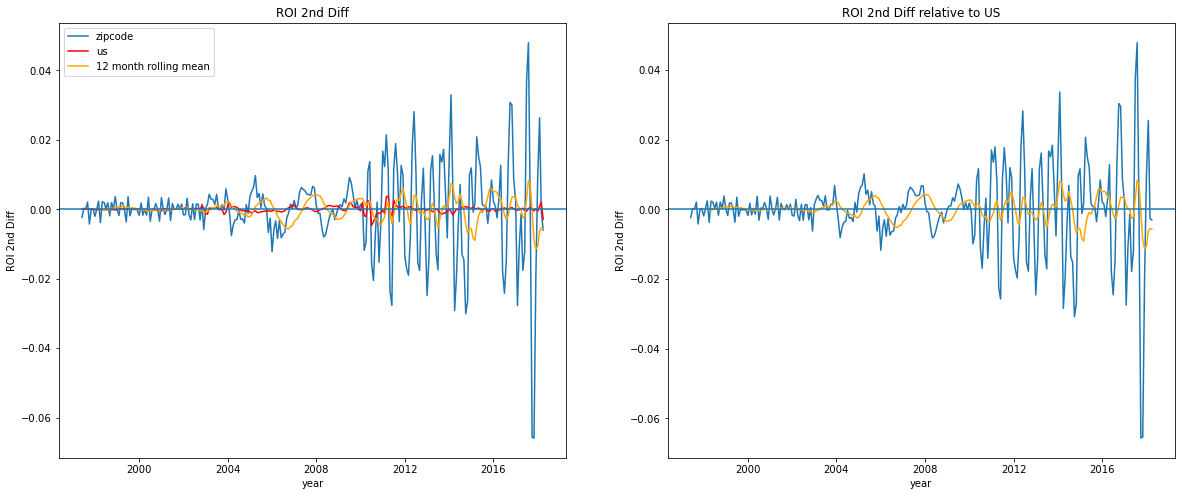

In [28]:
for column in melted_dfs_dict_1['Hawthorne'].columns.drop('value - 1ya'):
    plot_zip(melted_dfs_dict_1['Hawthorne'], column)
plt.savefig('images/hawthorne_plots.png')

These graphs of Hawthorne 32640's ROI shows that even though its most recent rolling average was the best in the country, ROI is trending downward toward the US average, with the second difference showing no indication of a coming upswing. It also appears to have strong covariance with the US housing market during the years leading up to and following the US mortgage crisis. With the exception of a single upswing it saw a weaker than average ROI during the recovery period up until the most recent price boom. This suggests that we should be skeptical about whether year over year ROI is the best metric in picking out good investments.

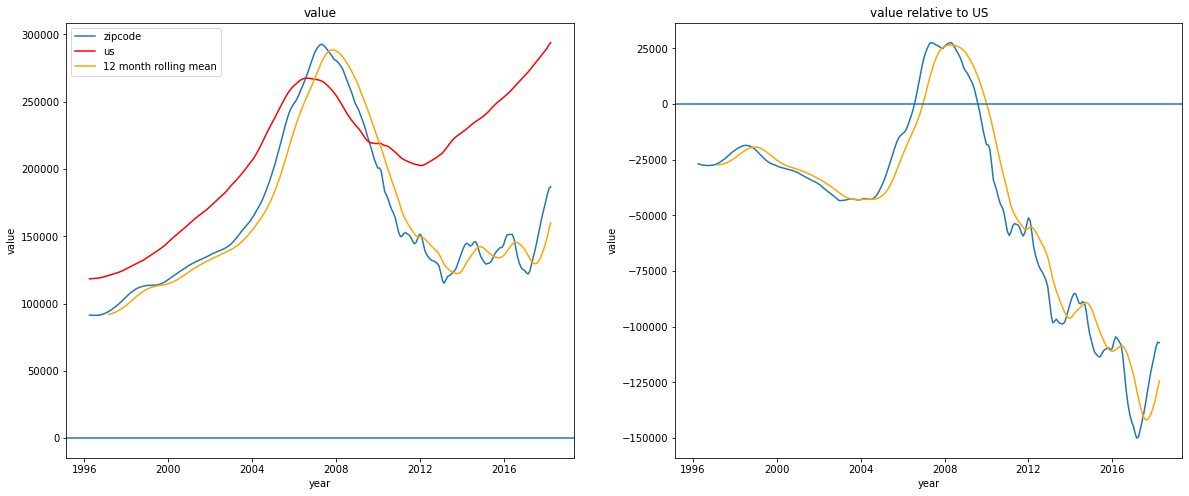

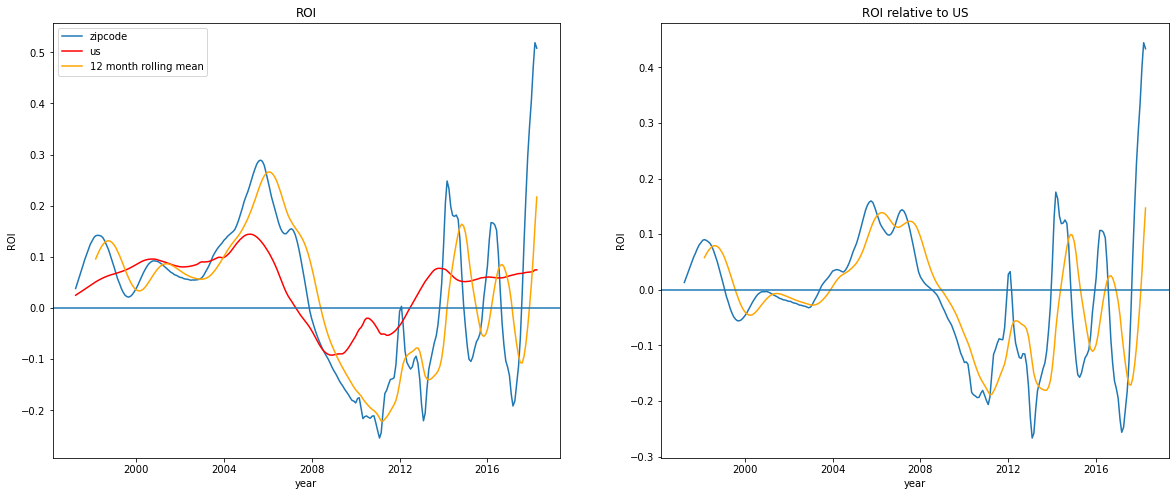

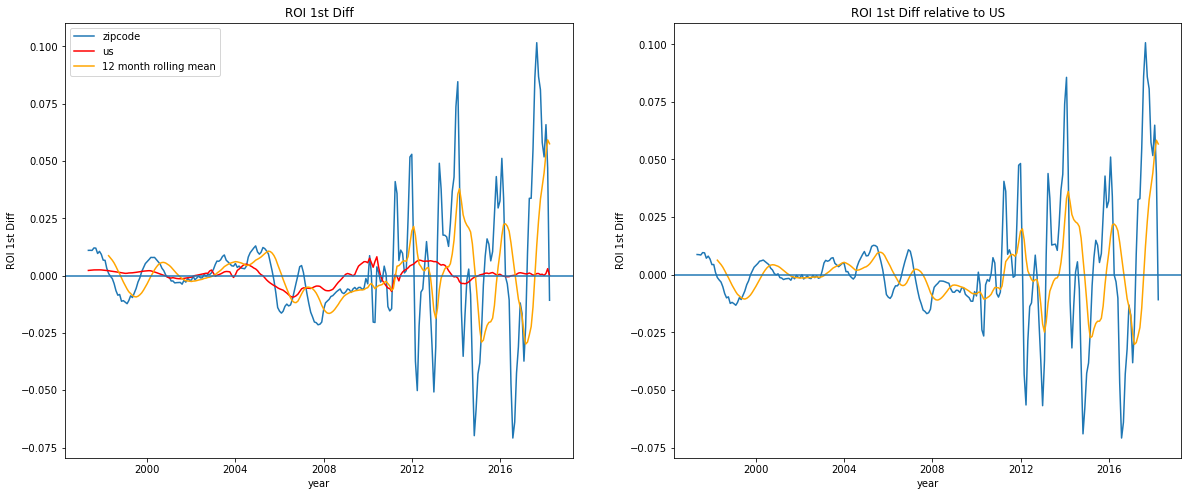

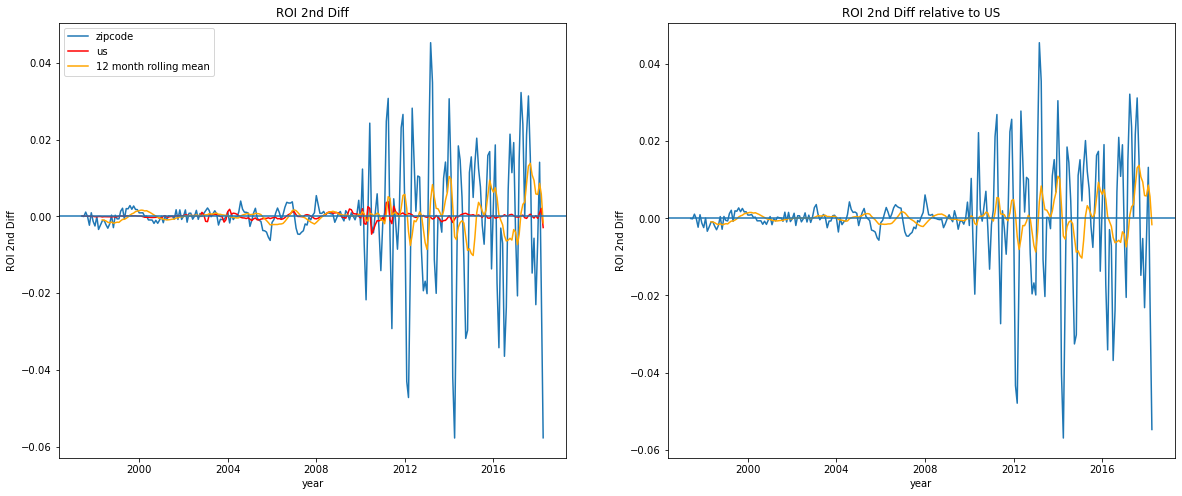

In [29]:
for column in melted_dfs_dict_1['Newark'].columns.drop('value - 1ya'):
    plot_zip(melted_dfs_dict_1['Newark'], column)
plt.savefig('images/newark_plots.png')

Unlike the Hawthorne Zip Code, Newark 07106 actually saw a higher than average median home price prior to the financial crisis. It's recovery has been halting, with two brief but aborted upswings prior to somewhat larger upswing that we're seeing today.

For Newark 07106, the fact that it had the highest average year-over-year increase in ROI conceals the fact that its ROI is now at the beginning of a downswing. This downswing is visible on the first differencing chart and shows up quantitatively in the metric for second differencing, which is below the US average for the past year. This doesn't mean that this zipcode isn't a good investment however, since it's possible that short term volatility may be concealing a longer-term upward trend.

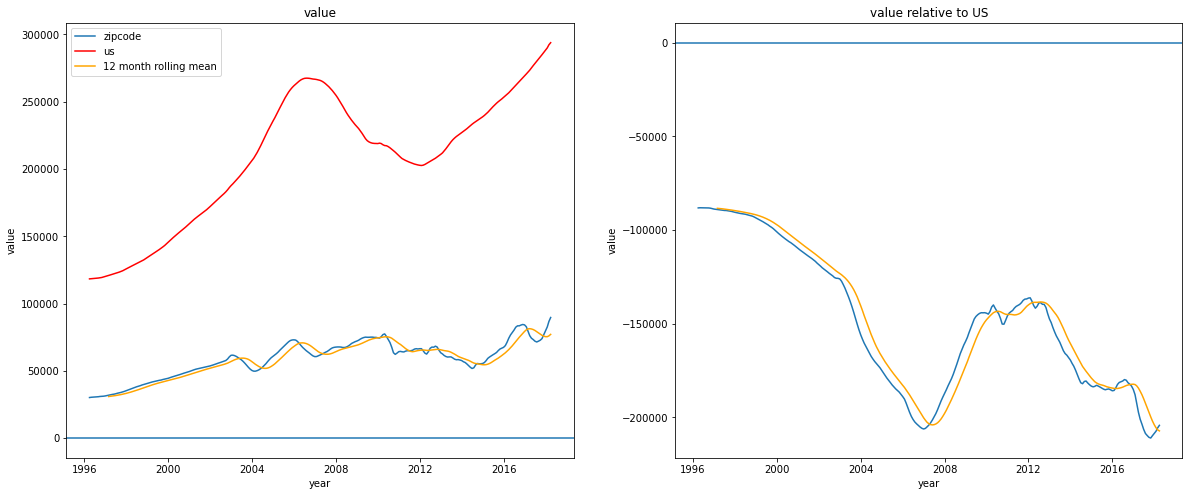

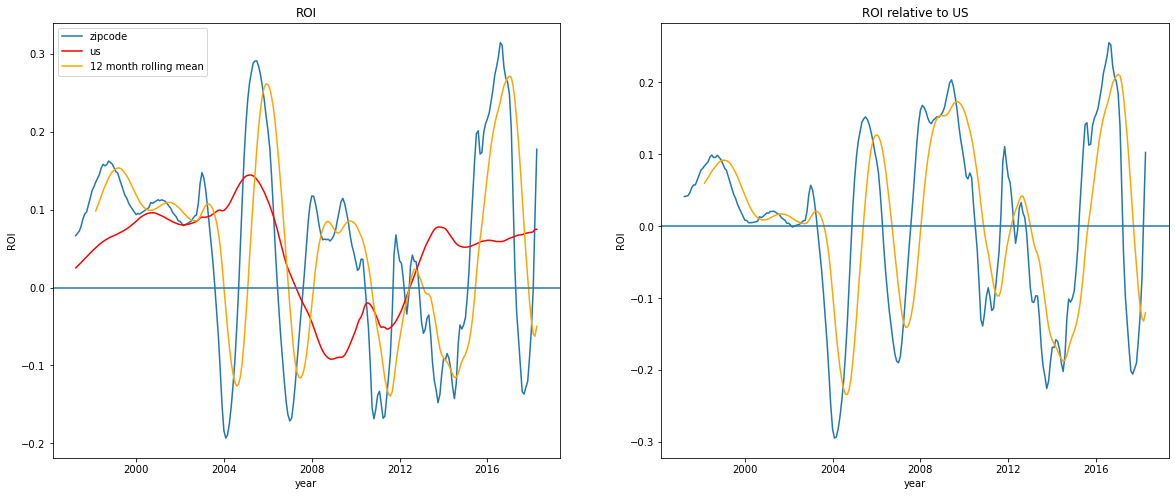

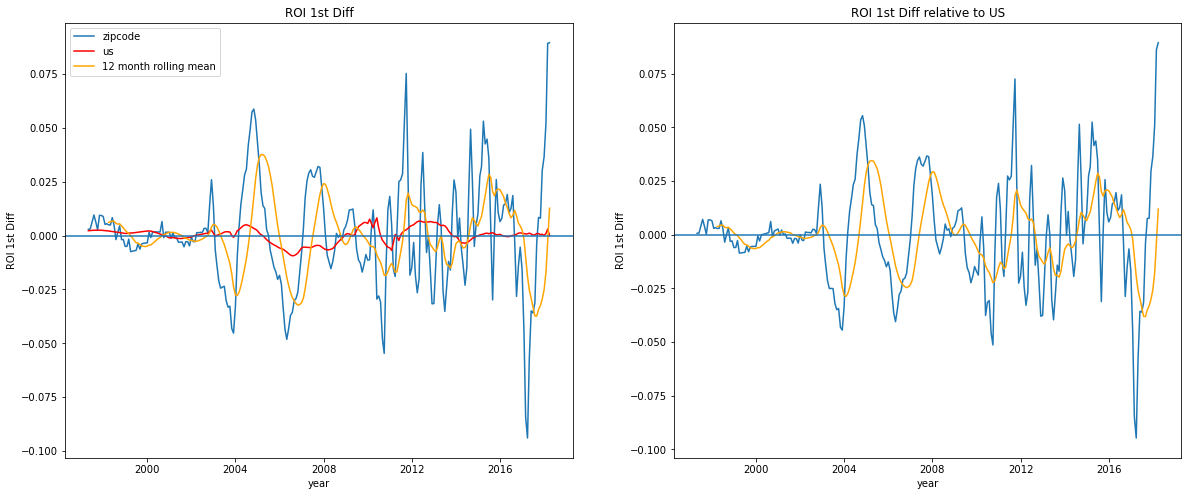

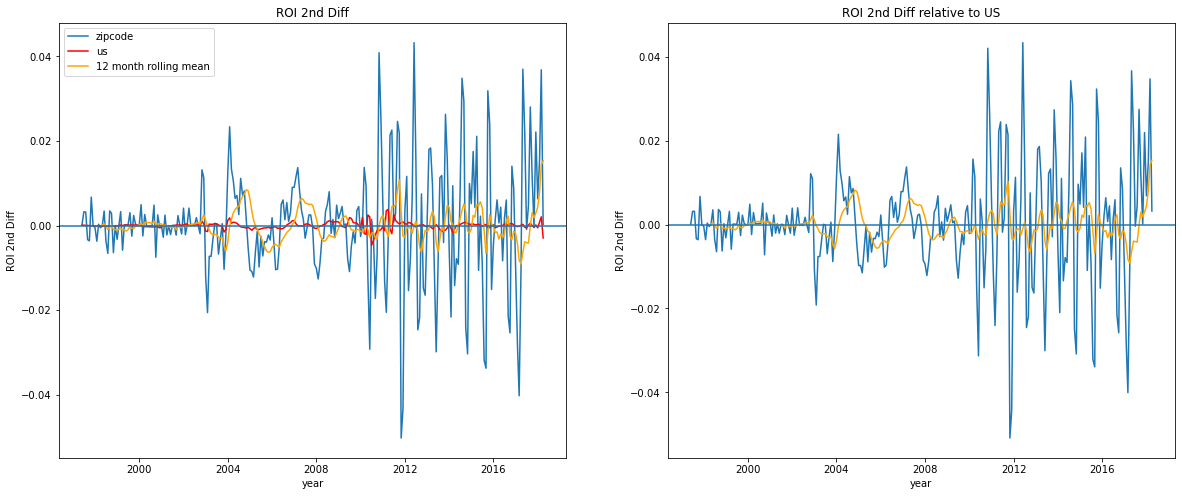

In [30]:
for column in melted_dfs_dict_1['Chelsea'].columns.drop('value - 1ya'):
    plot_zip(melted_dfs_dict_1['Chelsea'], column)
plt.savefig('images/chelsea_plots.png')

The Chelsea 74016 Zipcode is far less correlated with the US housing market than the previous two zipcodes examined. It saw a downturn prior to the mortgage crisis, and even though it was hit by a downturn early in the mortgage crisis, home values recovered faster than they did for the US as a whole. However, Hawthorne is also the poorest of the three zipcodes in terms of home prices and has never saw major spike in real estate prices to begin with, which accounts for its faster than average post-2007 recovery.

### General patterns

The most notable feature of these charts is the increase in home price volatility after 2010. Before the mortgage crisis, home prices tended to rise at a steady, predictable rate. During the housing bubble there a dramatic increase in home prices, but that increase was fairly uniform as was the fall in home prices after the crisis. 

After 2010 we see consistent and dramatic short term fluctuations in ROI for each of these zipcodes. So despite an overall upward trend in home prices, short term changes are much less uniform than they used to be. This indicates a transition to a new macroeconomic regime with an entirely new set of patterns in home price movements.

For this reason, it doesn't make sense to include pre-2010 home prices in our time series modeling, since we want our model to reflect the current macroeconomic regime. While a new macroeconomic regime might make obsolete the predictions our model makes, those changes would be outside the scope of an autoregressive model and would have to involve the inclusion of exogenous variables.

# Autocorrelation and Partial Autocorrelation

Before we build our time series model, we'll look briefly at autocorrelation and partial autocorrelation for each of the four zipcodes we examined above. Ideally each of the zipcodes should show the same autocorrelation and partial autocorrelation patterns, which would indicate that the same SARIMA model would do a good job at predicting each zipcode's ROI fluctuations.

Because 2nd differences show increased variance after 2010, it's unlikely that the best model for the post 2010 period is the same as the best model as for the pre-2010 period. Because of this, we'll restrict our autocorrelation analysis as well as our training data to the post-2010 period.

In [31]:
rcParams['figure.figsize'] = 16, 3

In [32]:
melted_dfs_dict_2 = {city: df['2010-04-01':]-us['2010-04-01':] for city, df in melted_dfs_dict_1.items()}

## Comparing ACFs and PCFs - No Differencing

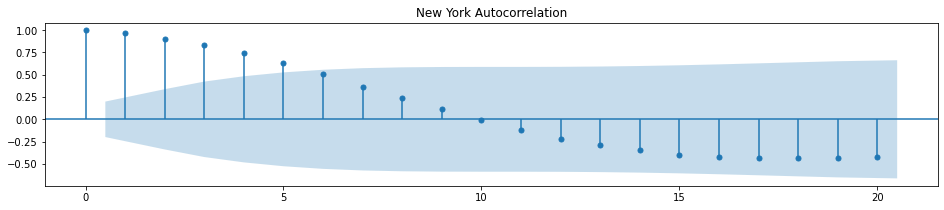

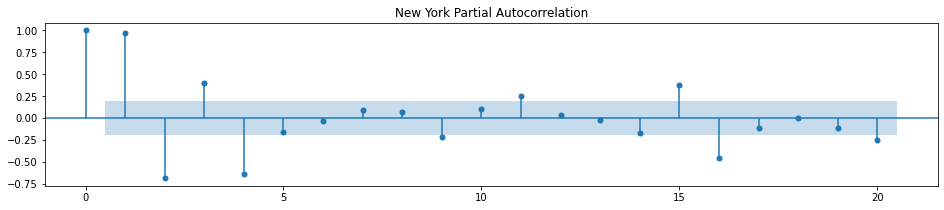

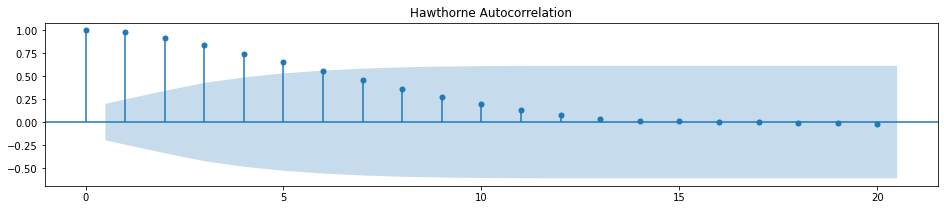

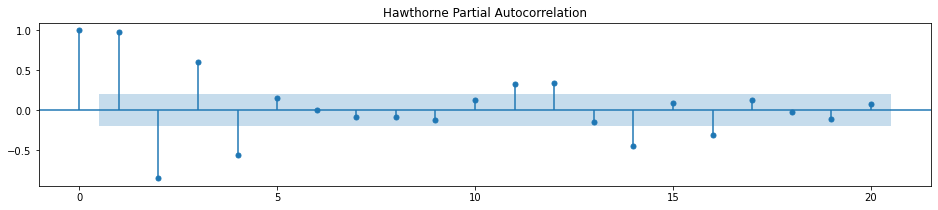

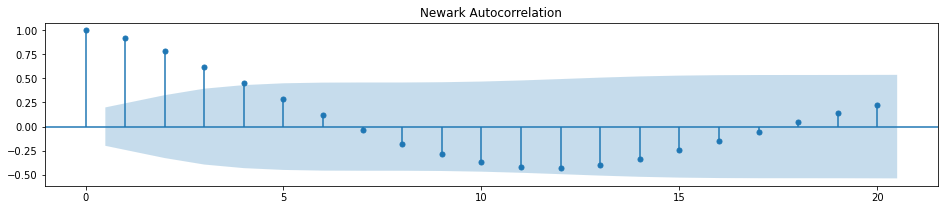

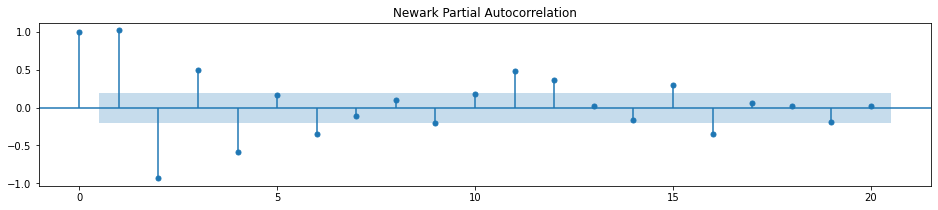

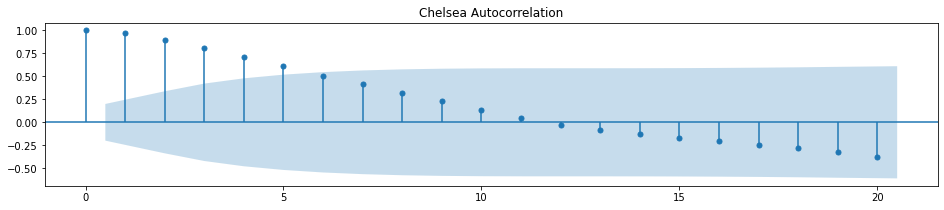

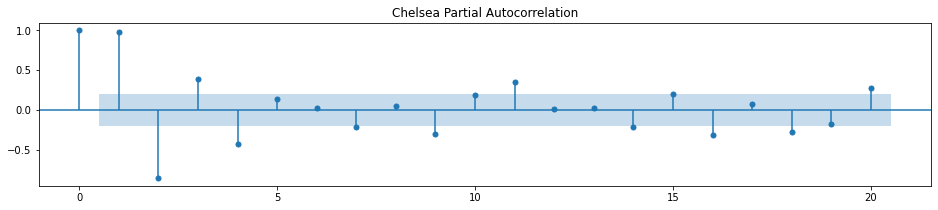

In [33]:
for city, df in melted_dfs_dict_2.items():
    rcParams['figure.figsize'] = 16, 3
    plot_acf(df['ROI'], title=f'{city} Autocorrelation');
    plot_pacf(df['ROI'], title=f'{city} Partial Autocorrelation', method='ols');

All zipcodes show the same patterns, with a tapering autocorrelation up to lags four and five and a diminishing oscillation in partial autocorrelation through lags four or five.

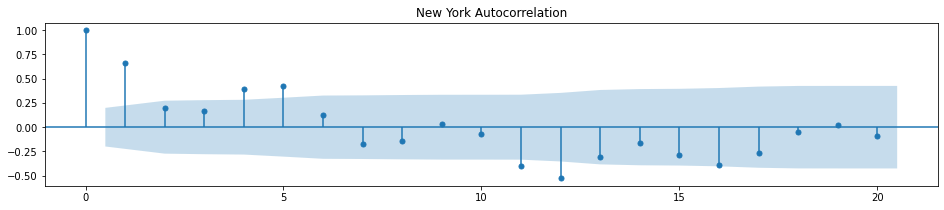

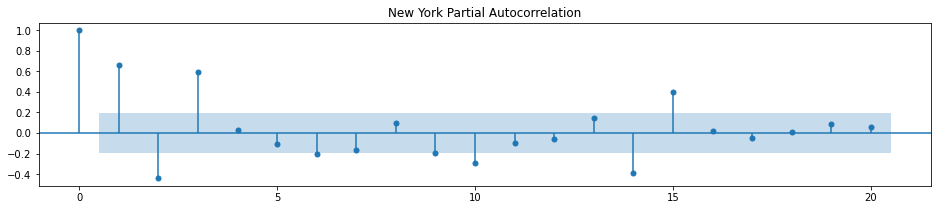

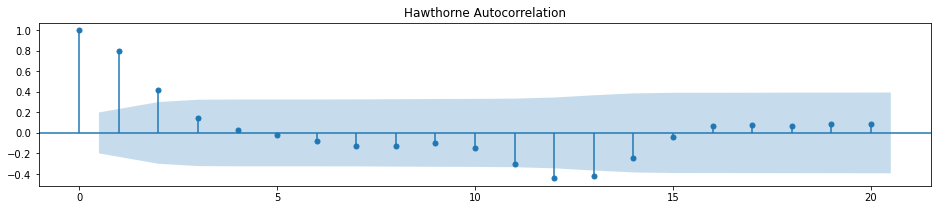

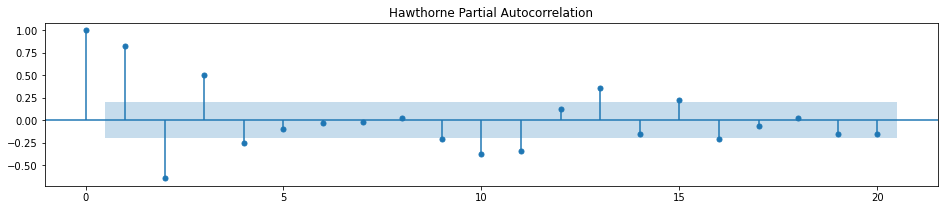

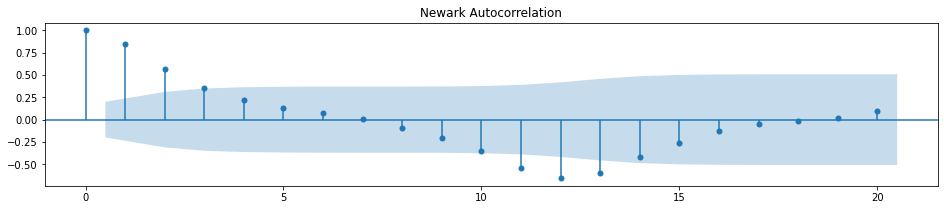

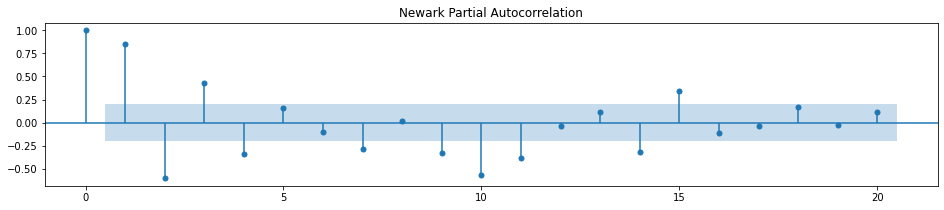

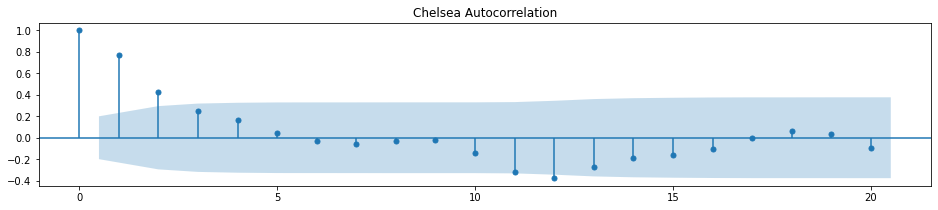

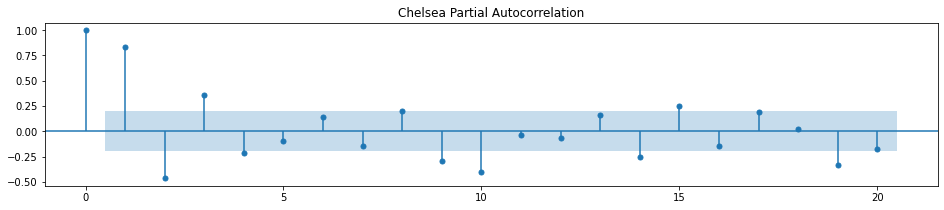

In [34]:
for city, df in melted_dfs_dict_2.items():
    rcParams['figure.figsize'] = 16, 3
    plot_acf(df['ROI 1st Diff'], title=f'{city} Autocorrelation');
    plot_pacf(df['ROI 1st Diff'], title=f'{city} Partial Autocorrelation', method='ols');

First differencing similarly shows consistent patterns, though for the New York zip code, autocorrelation tapers much more dramatically. We also see seasonal autocorrelation at a 12 month lag.

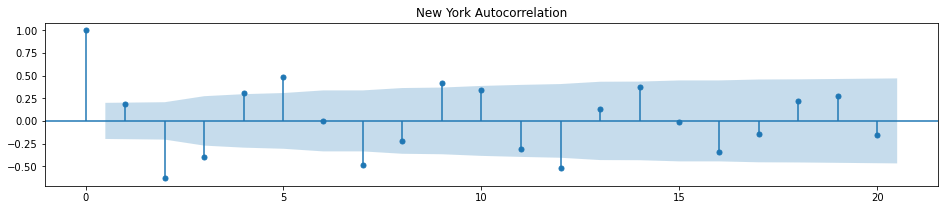

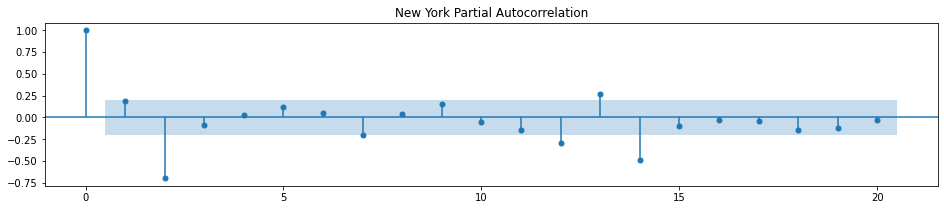

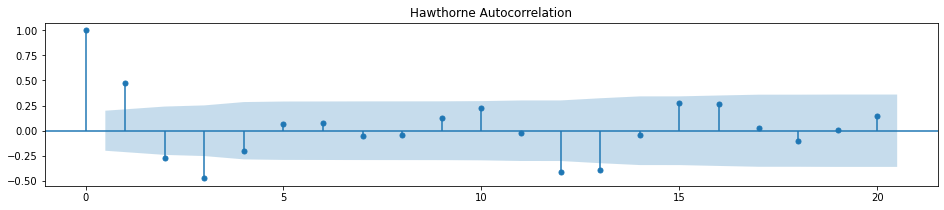

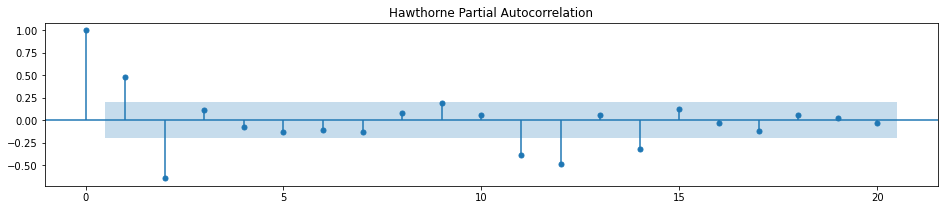

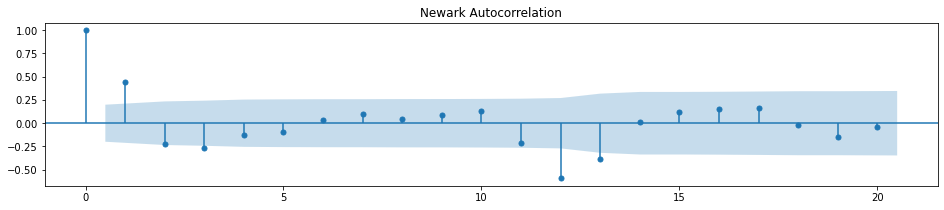

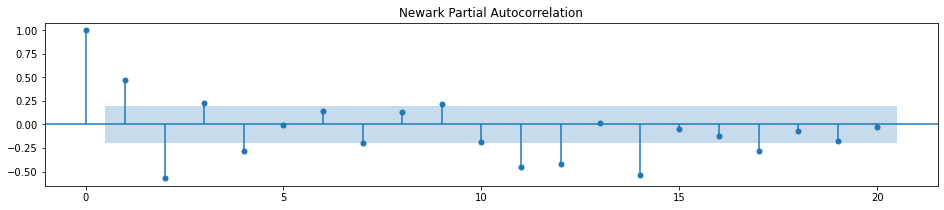

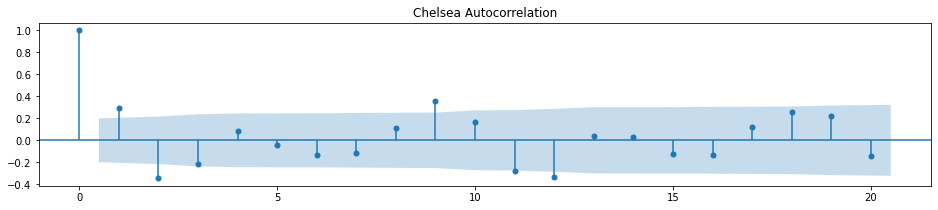

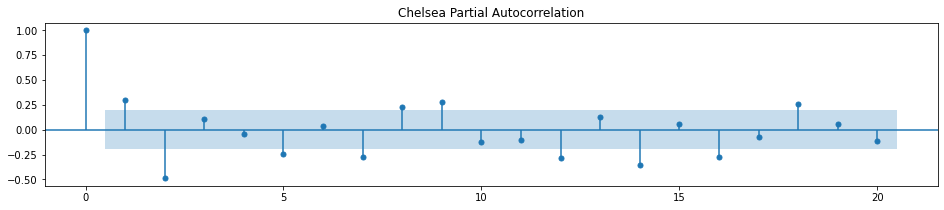

In [35]:
for city, df in melted_dfs_dict_2.items():
    rcParams['figure.figsize'] = 16, 3
    plot_acf(df['ROI 2nd Diff'], title=f'{city} Autocorrelation');
    plot_pacf(df['ROI 2nd Diff'], title=f'{city} Partial Autocorrelation', method='ols');

Results for second differencing show autocorrelation at the first two lags for most zipcodes, with the New York zipcode being the primary exception.

# Step 5: SARIMA Modeling

In [36]:
# list of zip codes for model validation

top_5_zips = list(top_5_values['RegionName'])
top_5_ROI_zips = list(top_5_ROI['RegionName'])
top_5_1st_Diff_zips = list(top_5_ROI_1st_Diff['RegionName'])
top_5_2nd_Diff_zips = list(top_5_ROI_2nd_Diff['RegionName'])
all_zips = top_5_zips + top_5_ROI_zips + top_5_1st_Diff_zips + top_5_2nd_Diff_zips

In [37]:
def long_df_fast(melted_data):
    
    '''
    Takes in a simple time series data frame and returns a new time series dataframe with columns for ROI, 
    WITHOUT columns for 1st Differencing or 2nd differencing.
    '''
    
    melt_shift_1yr = melted_data.shift(periods=12)
    melt_shift_1yr.rename(columns={'value':'value - 1ya'}, inplace=True)
    melt_lag = pd.concat([melted_data, melt_shift_1yr], axis=1)
    melt_lag['ROI'] = (melt_lag['value']-melt_lag['value - 1ya'])/melt_lag['value - 1ya']

    return melt_lag

## Testing a Baseline Model

For our baseline model, we'll use a simple AR(1) model. In this model year over year ROI for a given month is correlated with year over year ROI for the previous month. 

In [38]:
def validate_sarima(params, seasonal_params, zip_list):
    errors = []
    for zipcode in zip_list:
        zip_df = long_df_fast(melt_data(data[data['RegionName']==zipcode]))
        zip_us = zip_df-us
        zip_train = zip_us['2010-04-01':'2017-04-01']['ROI']
        
        sari_mod = SARIMAX(zip_train,
                                order=(params),
                                seasonal_order=(seasonal_params),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
        
        preds = sari_mod.predict(start='2017-05-01', end='2018-04-01')
        true = zip_us['2017-05-01':]['ROI']
        
        rmse = np.sqrt(((true - preds)**2).sum()/len(true))
        errors.append(rmse)

    return errors

In [39]:
params = [1, 0, 0]
seasonal_params = [0, 0, 0, 0]
errors_model_1 = validate_sarima(params, seasonal_params, all_zips)

In [40]:
np.mean(errors_model_1)

0.14159571269535015

Our average RMSE for all zipcodes is 0.14, which means that a simple 1st lag autoregression is around 0.14. This is considerable since current US average ROI is below 8%. How are these errors distributed?

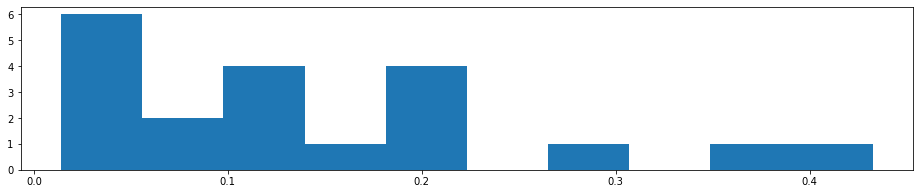

In [41]:
plt.hist(errors_model_1)
plt.show()

The highly non-normal distribution of errors indicates that we should take a closer look at the zipcodes in our data set to see if there is a different amount of error for each category of zipcode.

In [42]:
errors_baseline = [[all_zips[i], errors_model_1[i]] for i in range(len(all_zips))]

errors_baseline_df = pd.DataFrame(errors_baseline, columns=['zipcode', 'errors_baseline'])
errors_baseline_df

,zipcode,errors_baseline
0,10128,0.025545
1,94027,0.050513
2,90210,0.014011
3,33480,0.028831
4,94123,0.018209
5,32640,0.105343
6,32117,0.100005
7,33805,0.061511
8,7088,0.187297
9,66104,0.036249


A quick inspection of these zip codes tells us that the cities with the **least error** are the high value cities rather than the high ROI cities. It makes sense that these cities would have lower ROI but also lower variance, since the predictably robust real estate markets in cities like New York and LA are likely to see lower returns than more volatile, higher risk markets. A stable and predictably robust real estate is also likely to conform to an AR pattern rather than an MA pattern in which prices are more subject to trends and short term forces rather than previous values. 

On the other hand, the zipcodes with the **greatest error** are those selected for a high average ROI first difference. The reason for this is probably that our model wasn't sensitive enough to the volatility of these markets, which might be better represented by the inclusion of at least one MA term.

### Examining model parameters

We'll now look at the parameters for the best and worse performing zipcodes given the baseline model.

In [43]:
# 90210 - the best performing zipcode for the baseline model

zip_df = long_df_fast(melt_data(data[data['RegionName']==90210]))
zip_us = zip_df-us
zip_train = zip_us['2010-04-01':'2017-04-01']['ROI']
        
sari_mod = SARIMAX(zip_train,
                        order=(params),
                        seasonal_order=(seasonal_params),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

print(sari_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                    ROI   No. Observations:                   85
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 288.185
Date:                Fri, 16 Sep 2022   AIC                           -572.369
Time:                        16:15:59   BIC                           -567.507
Sample:                    04-01-2010   HQIC                          -570.415
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9963      0.009    108.845      0.000       0.978       1.014
sigma2      6.132e-05   1.16e-05      5.284      0.000    3.86e-05    8.41e-05
Ljung-Box (L1) (Q):                  56.56   Jarque-

In [44]:
# 07106 - the worst performing zipcode for the baseline model

zip_df = long_df_fast(melt_data(data[data['RegionName']==7106]))
zip_us = zip_df-us
zip_train = zip_us['2010-04-01':'2017-04-01']['ROI']
        
sari_mod = SARIMAX(zip_train,
                        order=(params),
                        seasonal_order=(seasonal_params),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

print(sari_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                    ROI   No. Observations:                   85
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 170.580
Date:                Fri, 16 Sep 2022   AIC                           -337.160
Time:                        16:15:59   BIC                           -332.299
Sample:                    04-01-2010   HQIC                          -335.206
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9851      0.033     30.249      0.000       0.921       1.049
sigma2         0.0010      0.000      6.437      0.000       0.001       0.001
Ljung-Box (L1) (Q):                  56.19   Jarque-

In the case of the 90210 zipcode (the zipcode with the smallest RMSE) the AR parameter (phi) is very close to 1 (0.9963) while the error parameter is 0.00006132.

For the 07106 zipcode (the zipcode with the greatest RMSE), the AR parameter (phi) is less close to 1 (0.9851) while the error parameter is a bit larger (0.0010). 

This means that given a simple AR model, year over year ROI for one month is likely to be almost identical to year over year ROI for the previous month. This is more true for 90210 than it is for for 07106, likely because 90210 is a perenially desirable zipcode while the desirability of 07106 is less stable and therefore more subject to short term volatility (which can be modeled with SARIMA) as well as exogenous factors (which can't be modeled with SARIMA).

## Selecting a SARIMA model through grid search

Ideally we would like to find a single SARIMA model that will perform well when fit to any zipcode. To determine the best features for such a model, we'll run a grid search using pdq = range(0,3) to select short term features and pdq = range(0, 2) to determine whether we should include features with a 1 year seasonal lag. The grid search outputs a series of average RMSE scores for each model based on test data performance.

In [45]:
p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))

ps = ds = qs = range(0, 2)

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(ps, ds, qs))]

In [46]:
'''DO NOT RUN. RESULT HAVE BEEN PICKLED
errors=[]
for comb in pdq:
    for combs in pdqs:
        params = comb
        seasonal_params = combs
        try:
            avg_rmse = validate_sarima(params, seasonal_params, all_zips)
        except:
            continue
        errors.append([comb, combs, avg_rmse])
        
with open('data/validation_errors_1.pickle', 'wb') as f:
    pickle.dump(errors, f)
    
'''

"DO NOT RUN. RESULT HAVE BEEN PICKLED\nerrors=[]\nfor comb in pdq:\n    for combs in pdqs:\n        params = comb\n        seasonal_params = combs\n        try:\n            avg_rmse = validate_sarima(params, seasonal_params, all_zips)\n        except:\n            continue\n        errors.append([comb, combs, avg_rmse])\n        \nwith open('data/validation_errors_1.pickle', 'wb') as f:\n    pickle.dump(errors, f)\n    \n"

In [47]:
with open('data/validation_errors_1.pickle', 'rb') as f:
    errors = pickle.load(f)

errors_mean = [[row[0], row[1], np.mean(row[2])] for row in errors]
               
ans_df = pd.DataFrame(errors_mean, columns=['pdq', 'pdqs', 'avg rmse'])
ans_df.sort_values(by='avg rmse').head()

,pdq,pdqs,avg rmse
117,"(1, 1, 2)","(1, 0, 1, 12)",0.113253
109,"(1, 1, 1)","(1, 0, 1, 12)",0.117254
189,"(2, 1, 2)","(1, 0, 1, 12)",0.117678
113,"(1, 1, 2)","(0, 0, 1, 12)",0.119706
116,"(1, 1, 2)","(1, 0, 0, 12)",0.120256


The grid search selected by the model has pdq values of (1, 1, 2) and pdqs values of (1, 0, 1, 12).

This can be interpreted to mean that in the short term, ROI is best modeled by regressing on the rate of increase in ROI, whereas year over year, ROI is best modeled by regressing on the value for the previous year. The two nonseasonal theta terms reflect volatility in home prices over a shorter term whereas the seasonal theta term reflects the fact that over a one year period, random-walk effects are less important. 


Overall, the average RMSE for our best model is 11.3 which is a three point improvement on our previous model. How did it perform on each category of zipcode?

In [48]:
params = [1, 1, 2]
seasonal_params = [1, 0, 1, 12]
errors_model_2 = validate_sarima(params, seasonal_params, all_zips)

In [49]:
errors_comparison = [[all_zips[i], errors_model_1[i], errors_model_2[i]] for i in range(len(all_zips))]

errors_comparison_df = pd.DataFrame(errors_comparison, columns=['zipcode', 'errors_baseline', 'errors_grid_search'])

In [50]:
errors_comparison_df['baseline improved?'] = errors_comparison_df['errors_grid_search']<errors_comparison_df['errors_baseline']
errors_comparison_df

,zipcode,errors_baseline,errors_grid_search,baseline improved?
0,10128,0.025545,0.047605,False
1,94027,0.050513,0.024467,True
2,90210,0.014011,0.012928,True
3,33480,0.028831,0.025949,True
4,94123,0.018209,0.046574,False
5,32640,0.105343,0.086194,True
6,32117,0.100005,0.064866,True
7,33805,0.061511,0.119117,False
8,7088,0.187297,0.150653,True
9,66104,0.036249,0.126457,False


In [51]:
# number of zipcodes which saw improvement under the new model.

errors_comparison_df['baseline improved?'].sum()

15

In [52]:
# errors for top value zipcodes, baseline 

errors_comparison_df.iloc[0:5, 1:].mean()

errors_baseline       0.027422
errors_grid_search    0.031505
baseline improved?    0.600000
dtype: float64

In [53]:
# errors for top ROI zipcodes

errors_comparison_df.iloc[5:10, 1:].mean()

errors_baseline       0.098081
errors_grid_search    0.109457
baseline improved?    0.600000
dtype: float64

In [54]:
# errors for top ROI first difference zipcodes

errors_comparison_df.iloc[10:15, 1:].mean()

errors_baseline       0.296931
errors_grid_search    0.187326
baseline improved?    1.000000
dtype: float64

In [55]:
# errors for top ROI second difference zipcodes

errors_comparison_df.iloc[15:20, 1:].mean()

errors_baseline       0.143949
errors_grid_search    0.124724
baseline improved?    0.800000
dtype: float64

This model shows lower RMSEs for 15 out of the 20 zipcodes. However, the total amount of error was slightly greater for high value zipcodes as well as the zipcodes with the highest ROI. The most dramatic change was the decrease of error for the zipcodes with the highest first difference. For these zipcodes, error went down from 0.3 to 0.19. These zipcodes have the highest error of any category regardless of the model used, and the use of the (1, 1, 2)X(1, 0, 1, 12) model brought their error down significantly, which was why the average error across categories was lowest for this model.

## Model Forecasts

We'll now look at the performance of our model for the top zipcode in each of our four categories as well as our model's predictions for the following year.

In [56]:
preds_dict = {}
actual_dict = {}
for zipcode in zip_dict_1.keys():
    ROI_data = melted_dfs_dict_1[zip_dict_1[zipcode]]['ROI']
    train = ROI_data['2010-04-01':'2017-04-01']
    sari_mod = SARIMAX(train,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
    preds = sari_mod.get_prediction(start='2017-05-01', end='2018-04-01', dynamic=True)
    conf = preds.conf_int()
    preds_dict[zipcode] = preds
    actual_dict[zipcode] = ROI_data['2010-04-01':]

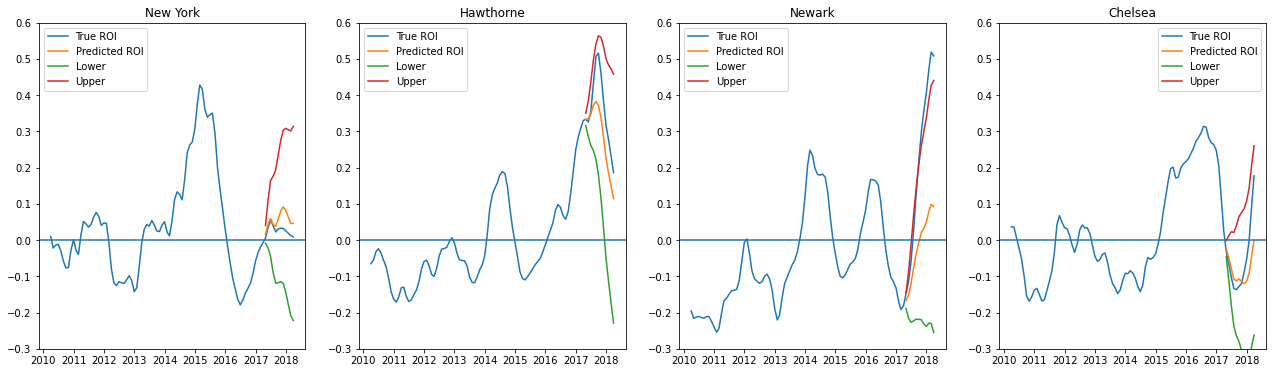

In [57]:
zip_list = list(zip_dict_1.keys())

fig, axs = plt.subplots(1, len(zip_list), figsize=(22, 6))
for i, ax in enumerate(axs):
       
    ax.set_ylim(bottom=-0.3, top=0.6)
    ax.plot(actual_dict[zip_list[i]], label='True ROI')
    ax.plot(preds_dict[zip_list[i]].predicted_mean, label='Predicted ROI')
    ax.plot(preds_dict[zip_list[i]].conf_int(), label=['Lower', 'Upper'])
    ax.set_title(zip_dict_1[zip_list[i]])
    ax.axhline(y=0)
    
    ax.legend()
plt.savefig('images/top_four_predictions.png')

Our model slightly overpredicted the performance of the New York housing market while underpredicting the performance of the housing markets in Hawthorne, Newark and Chelsea. In all cases, the model successful predicted dips and rises in ROI though the size of the dips and rises were a source of error. In Newark the housing market actually outperformed even the upper confidence interval predicted by the model. 

**It's obvious that the reason for the large error for high first difference zip codes is that these zipcode's increases in ROI were so dramatic that they defied any identifiable market patterns. It's therefore likely that even the best model will be unable to predict these kinds of price spikes with certainty.**

In [58]:
actual_dict = {}
forecast_dict = {}
for zipcode in zip_dict_1.keys():
    ROI_data = melted_dfs_dict_1[zip_dict_1[zipcode]]['ROI']
    train = ROI_data['2010-04-01':]
    sari_mod = SARIMAX(train,
                                    order=(1, 1, 2),
                                    seasonal_order=(1, 0, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False).fit(disp=False)
    forecasts = sari_mod.get_prediction(start='2018-05-01', end='2019-04-01', dynamic=True)
    forecast_dict[zipcode] = forecasts
    actual_dict[zipcode] = train

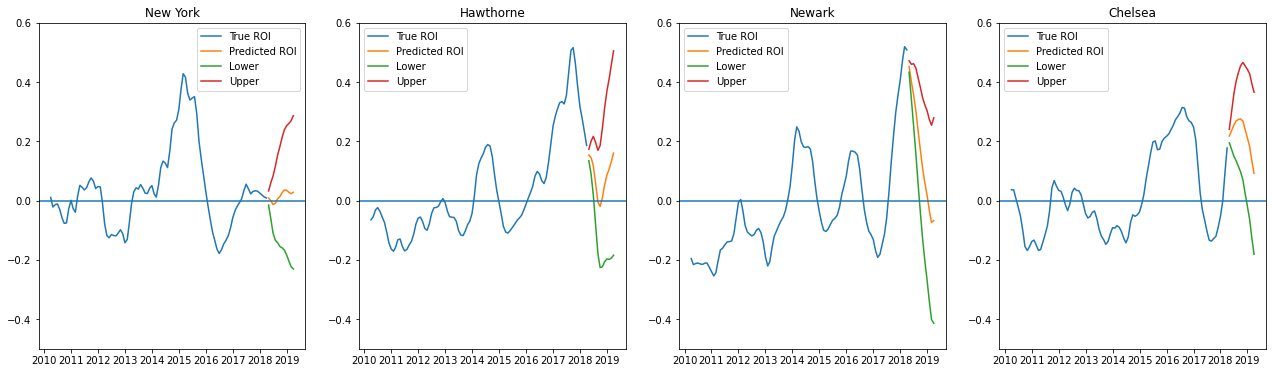

In [59]:
fig, axs = plt.subplots(1, len(zip_list), figsize=(22, 6))
for i, ax in enumerate(axs):
       
    ax.set_ylim(bottom=-0.5, top=0.6)
    ax.plot(actual_dict[zip_list[i]], label='True ROI')
    ax.plot(forecast_dict[zip_list[i]].predicted_mean, label='Predicted ROI')
    ax.plot(forecast_dict[zip_list[i]].conf_int(), label=['Lower', 'Upper'])
    ax.set_title(zip_dict_1[zip_list[i]])
    ax.axhline(y=0)
    
    ax.legend()
plt.savefig('images/top_four_forecasts.png')

While three of the four cities are predicted to beat the average US ROI, Newark is projected to fall short of the average US ROI. It also shows a risk of a significant (40%) fall below US ROI, whereas for all other zipcodes there is a comparable of risk of only around -20% decline in value relative to the US average. Overall, Hawthorne shows the most promising growth, with a high predicted mean and an upwardly sloping trendline, whereas Chelsea shows a high predicted mean but a downwardly sloping trend line.

### Model Parameters

We can better understand these models by looking at their parameters.

In [60]:
zip_dict_1

{10128: 'New York', 32640: 'Hawthorne', 7106: 'Newark', 74016: 'Chelsea'}

In [61]:
# hawthorne parameters

ROI_data = melted_dfs_dict_1[zip_dict_1[7106]]['ROI']
train = ROI_data['2010-04-01':]
sari_mod = SARIMAX(train,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
sari_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  ROI   No. Observations:                   97
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 256.707
Date:                              Fri, 16 Sep 2022   AIC                           -501.415
Time:                                      16:16:07   BIC                           -487.048
Sample:                                  04-01-2010   HQIC                          -495.651
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4604      0.132      3.497      0.000       0.202       0.718
ma.L1          1.4011      0.091     15.344      0.000       1.222       1.580
ma.L2          0.7469      0.099      7.535      0.000       0.553       0.941
ar.S.L12      -0.4376      0.132     -3.309      0.001      -0.697      -0.178
ma.S.L12      -0.4397      0.143     -3.077      0.002      -0.720      -0.160
sigma2      9.694e-05   1.44e-05      6.724      0.000    6.87e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.87   Prob(JB):                         0.41
Heteroskedasticity (H):               1.49   Skew:                            -0.25
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The most noteworthy parameter in this model is theta lag 2, which has a coefficient of 1.4011. This large coefficient indicates that trends over a two month period tend to be reinforced rather than reversed in the short term. The negative coefficients at a 12 month lag show that these short term trends tend to be reversed over a longer period. This pattern is visible on our graph, which shows a short term decline followed by a seasonal reversal.

In [62]:
# newark parameters

ROI_data = melted_dfs_dict_1[zip_dict_1[74016]]['ROI']
train = ROI_data['2010-04-01':]
sari_mod = SARIMAX(train,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
sari_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  ROI   No. Observations:                   97
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 240.835
Date:                              Fri, 16 Sep 2022   AIC                           -469.670
Time:                                      16:16:08   BIC                           -455.303
Sample:                                  04-01-2010   HQIC                          -463.906
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0713      0.147      0.486      0.627      -0.216       0.359
ma.L1          1.5465      0.085     18.240      0.000       1.380       1.713
ma.L2          0.8886      0.078     11.454      0.000       0.737       1.041
ar.S.L12      -0.2968      0.137     -2.174      0.030      -0.564      -0.029
ma.S.L12      -1.6903      0.502     -3.370      0.001      -2.673      -0.707
sigma2      4.717e-05   2.45e-05      1.929      0.054   -7.66e-07    9.51e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 5.95
Prob(Q):                              0.72   Prob(JB):                         0.05
Heteroskedasticity (H):               0.84   Skew:                            -0.32
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For Newark we see an insignificant AR(1) term, a high positive theta value at lag 1 (1.5465) as well as a strongly negative theta value at lag 12 (-1.6903). These coefficients model Newark's steep spikes and dips as well as the regularity with which these trends are reversed over a twelve month period.

## A Universal Model?

While the (1, 1, 2)x(1, 0, 1, 12) SARIMA model performed better on some zip codes than on others, its overall strong performance suggests that perhaps it could be used to applied to all zipcodes in the US. If it's a model with universal applicability than in theory we could use it to predict ROI for every zip code and then select the zipcodes with the best forecasted performance for the next twelve months.

Below, we run through every zip code in the US and get both the predicted mean and the lower confidence interval for every zipcode. We then examine the top 5 zip codes sorted by highest lower confidence interval.

In [63]:
'''DO NOT RUN. RESULTS HAVE BEEN PICKLED.


forecasts = []

for zipcode in list(data['RegionName']):
    zip_df = long_df_fast(melt_data(data[data['RegionName']==zipcode]))
    zip_us = zip_df-us
    zip_train = zip_us['2010-04-01':]['ROI']
        
    sari_mod = SARIMAX(zip_train,
                            order=(1, 1, 2),
                            seasonal_order=(1, 0, 1, 12),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()
    forecast = sari_mod.get_prediction(start='2018-05-01', end='2019-04-01')
    predicted_mean = forecast.predicted_mean['2019-04-01']
    lower_interval = list(forecast.conf_int().loc['2019-04-01',:])[0]
    forecasts.append([zipcode, predicted_mean, lower_interval])

with open('data/forecasts.pickle', 'wb') as f:
    pickle.dump(forecasts, f)
'''

"DO NOT RUN. RESULTS HAVE BEEN PICKLED.\n\n\nforecasts = []\n\nfor zipcode in list(data['RegionName']):\n    zip_df = long_df_fast(melt_data(data[data['RegionName']==zipcode]))\n    zip_us = zip_df-us\n    zip_train = zip_us['2010-04-01':]['ROI']\n        \n    sari_mod = SARIMAX(zip_train,\n                            order=(1, 1, 2),\n                            seasonal_order=(1, 0, 1, 12),\n                            enforce_stationarity=False,\n                            enforce_invertibility=False).fit()\n    forecast = sari_mod.get_prediction(start='2018-05-01', end='2019-04-01')\n    predicted_mean = forecast.predicted_mean['2019-04-01']\n    lower_interval = list(forecast.conf_int().loc['2019-04-01',:])[0]\n    forecasts.append([zipcode, predicted_mean, lower_interval])\n\nwith open('data/forecasts.pickle', 'wb') as f:\n    pickle.dump(forecasts, f)\n"

In [64]:
with open('data/forecasts.pickle', 'rb') as f:
    forecasts = pickle.load(f)

In [65]:
big_predictions_df = pd.DataFrame(forecasts, columns=['zipcode', 'predicted mean', 'lower interval'])

In [66]:
big_predictions_df.sort_values(by='lower interval', ascending=False)

,zipcode,predicted mean,lower interval
6715,70121,0.333956,0.152095
8816,72837,0.273015,0.112034
6514,29601,0.252431,0.103501
3936,34691,0.256219,0.080849
9190,46996,0.188035,0.065623
...,...,...,...
7192,18509,-0.079805,-0.436537
10000,25320,-0.081316,-0.473907
11114,3598,-0.328758,-0.497421
3566,70815,-0.301707,-0.603594


In [67]:
top_5_lower_interval = big_predictions_df.sort_values(by='lower interval', ascending=False).head()
top_5_lower_interval

,zipcode,predicted mean,lower interval
6715,70121,0.333956,0.152095
8816,72837,0.273015,0.112034
6514,29601,0.252431,0.103501
3936,34691,0.256219,0.080849
9190,46996,0.188035,0.065623


These predicted means are quite high! If we can trust this model, then zipcodes whose ROI is 30 points above the US average should be great investments. However, we haven't yet validated this model by checking its errors against a training set or performing a grid search so we should be suspicious of these results.

## Validating model for new set of zipcodes

In [68]:
# Dictionary of zip codes and city names 

zip_dict_2 = {data.iloc[row, 1]: data.iloc[row, 2] for row in top_5_lower_interval.index}

In [69]:
prediction_list = []

for code, name in zip_dict_2.items():
    prediction_dict = {}
    
    zip_df = long_df_fast(melt_data(data[data['RegionName']==code]))
    zip_us = zip_df-us
    zip_train = zip_us['2010-04-01':'2017-04-01']['ROI']
    
    sari_mod = SARIMAX(zip_train,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
    prediction = sari_mod.get_prediction(start='2017-05-01', end='2018-04-01', dynamic=True)
    prediction_dict['name'] = name
    prediction_dict['zipcode'] = code
    prediction_dict['full'] = zip_us['ROI']
    prediction_dict['prediction'] = prediction
    prediction_dict['rmse'] = np.sqrt(((zip_us['2017-05-01':]['ROI']-prediction.predicted_mean)**2).sum())
    prediction_list.append(prediction_dict)

In [70]:
std_errors = [[dictionary['name'], dictionary['zipcode'], dictionary['rmse']] for dictionary in prediction_list]
std_df = pd.DataFrame(std_errors, columns=['city', 'zipcode','rmse'])
std_df

,city,zipcode,rmse
0,Jefferson,70121,1.084358
1,Dover,72837,0.128446
2,Greenville,29601,0.200461
3,Holiday,34691,0.077707
4,Winamac,46996,0.100640


In [71]:
std_df['rmse'].mean()

0.31832244041691643

In [72]:
std_df['rmse'][1:].mean()

0.12681365161343922

While four of the zipcodes have RMSEs within an expected range, the RMSE for Jefferson is extremely high.

Below we examine the charts for each of these zipcodes to see if we can identify any patterns. In the following chart I've included the entire time series so we can look at the long term history of these real estate markets.

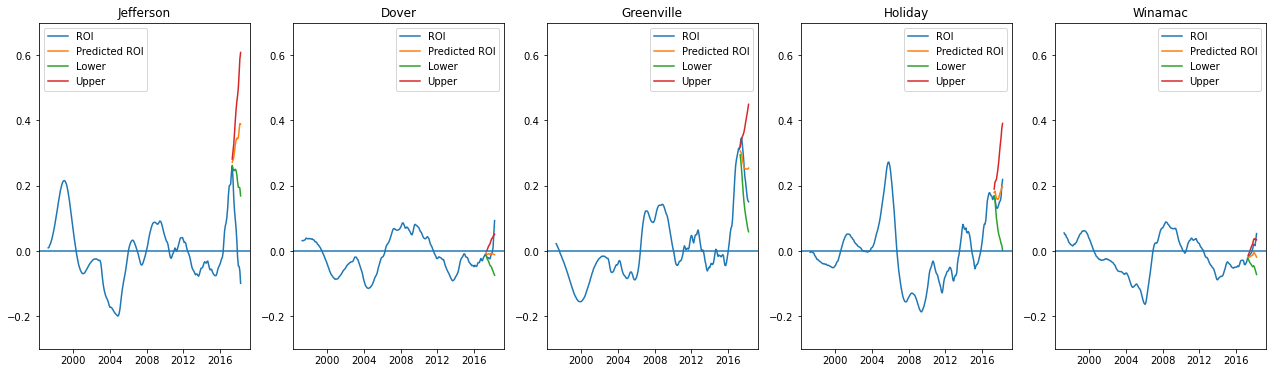

In [73]:
fig, axs = plt.subplots(1, 5, figsize=(22, 6))
for i, ax in enumerate(axs):
    ax.set_ylim(bottom=-0.3, top=0.7)
    ax.plot(prediction_list[i]['full'], label='ROI')
    ax.plot(prediction_list[i]['prediction'].predicted_mean, label='Predicted ROI')
    ax.plot(prediction_list[i]['prediction'].conf_int(), label=['Lower', 'Upper'])
    ax.set_title(prediction_list[i]['name'])
    ax.axhline(y=0)
    ax.legend()

Next we'll look at the same plot, but zoomed in for the post 2010 period.

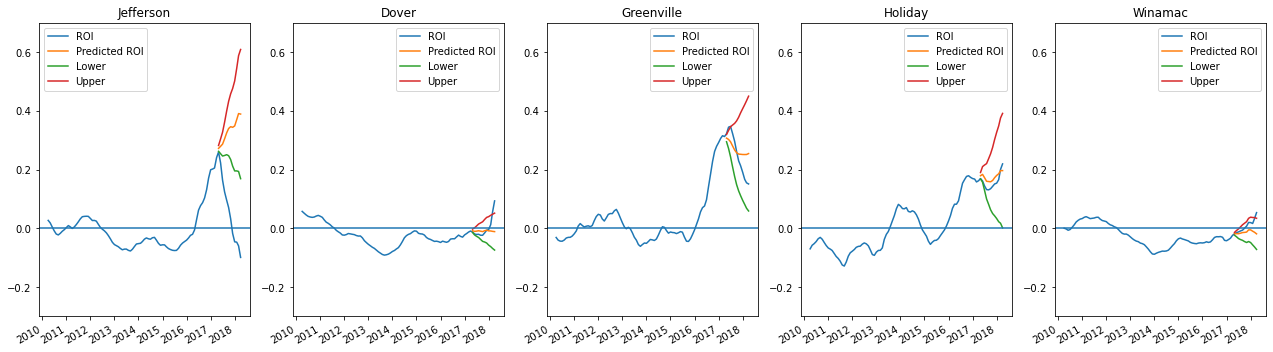

In [74]:
fig, axs = plt.subplots(1, 5, figsize=(22, 6))
for i, ax in enumerate(axs):
    ax.set_ylim(bottom=-0.3, top=0.7)
    ax.plot(prediction_list[i]['full']['2010-04-01':], label='ROI')
    ax.plot(prediction_list[i]['prediction'].predicted_mean, label='Predicted ROI')
    ax.plot(prediction_list[i]['prediction'].conf_int(), label=['Lower', 'Upper'])
    ax.set_title(prediction_list[i]['name'])
    ax.axhline(y=0)
    ax.legend()
fig.autofmt_xdate()
plt.savefig('images/top_5_predictions.png')

### Patterns

As the high level of error indicates, predictions for Jefferson were extremely inaccurate.

Other than that, these zipcodes show a variety of patterns with some of them currently seeing a downturn in home prices while others are at the beginning of an upturn.

With the exception of Holiday, all of them saw above average performance in the years following the mortgage crisis followed by below average performance during the recovery followed by a recent spike. Dover and Winnamac then underperformed significantly during the recovery, while Greenville and Jefferson experienced dramatic and belated growth, which was then quickly reversed.

Holiday is most closely correlated with overall housing market trends, having seen a spike prior to 2007, a deep crash, and a steady recovery. 

It's likely that except for Holiday, none of these zipcodes were significantly affected by the pre-2007 housing boom and therefore were similarly less affected by the crash. We would therefore expect them to follow different patterns of price fluctuations since they have historically occupied an inferior position in the US real estate market.

## Forecasts

Next we'll look at the forecasts for each of these models. It was on the basis of these forecasts that we picked these models out, so we should expected them to be extremely positive.

In [75]:
forecast_list = []

for code, name in zip_dict_2.items():
    forecast_dict = {}
    
    zip_df = long_df_fast(melt_data(data[data['RegionName']==code]))
    zip_us = zip_df-us
    zip_train = zip_us['2010-04-01':]['ROI']
    
    sari_mod = SARIMAX(zip_train,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
    forecast = sari_mod.get_prediction(start='2018-05-01', end='2019-04-01', dynamic=True)
    forecast_dict['name'] = name
    forecast_dict['zipcode'] = code
    forecast_dict['full'] = zip_us['ROI']
    forecast_dict['forecast'] = forecast
    forecast_list.append(forecast_dict)

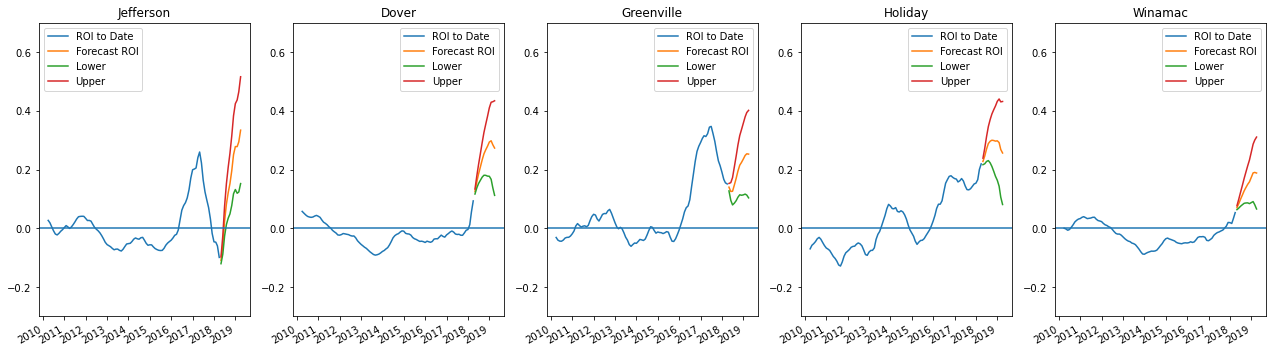

In [76]:
fig, axs = plt.subplots(1, 5, figsize=(22, 6))
for i, ax in enumerate(axs):
    ax.set_ylim(bottom=-0.3, top=0.7)
    ax.plot(forecast_list[i]['full']['2010-04-01':], label='ROI to Date')
    ax.plot(forecast_list[i]['forecast'].predicted_mean, label='Forecast ROI')
    ax.plot(forecast_list[i]['forecast'].conf_int(), label=['Lower', 'Upper'])
    ax.set_title(forecast_list[i]['name'])
    ax.axhline(y=0)
    ax.legend()
fig.autofmt_xdate()
plt.savefig('images/top_5_forecasts.png')

## Feature Selection Round 2: Custom SARIMA Models

It's possible that the universal model we selected is not in fact the best model for these zipcodes and that a better model might yield more modest results. We'll therefore perform a separate feature selection on each model and determine whether the results obtained for custom models are similar to the result obtained for the universal model.

In [77]:
five_zips = list(std_df['zipcode'])

In [78]:
five_zips

[70121, 72837, 29601, 34691, 46996]

In [79]:
'''DO NOT RUN. RESULT HAVE BEEN PICKLED!!

errors=[]
for comb in pdq:
    for combs in pdqs:
        params = comb
        seasonal_params = combs
        try:
            avg_rmse = validate_sarima(params, seasonal_params, five_zips)
        except:
            continue
        errors.append([comb, combs]+avg_rmse)
        
with open('data/validation_errors_2.pickle', 'wb') as f:
    pickle.dump(errors, f)
'''

"DO NOT RUN. RESULT HAVE BEEN PICKLED!!\n\nerrors=[]\nfor comb in pdq:\n    for combs in pdqs:\n        params = comb\n        seasonal_params = combs\n        try:\n            avg_rmse = validate_sarima(params, seasonal_params, five_zips)\n        except:\n            continue\n        errors.append([comb, combs]+avg_rmse)\n        \nwith open('data/validation_errors_2.pickle', 'wb') as f:\n    pickle.dump(errors, f)\n"

In [80]:
with open('data/validation_errors_2.pickle', 'rb') as f:
    errors = pickle.load(f)

In [81]:
combs_dataframe = pd.DataFrame(errors, columns=['comb', 'combs']+list(std_df['zipcode']))

for zipcode in list(std_df['zipcode']):

    best_sarima = combs_dataframe.loc[:, ['comb', 'combs', zipcode]].sort_values(by=zipcode).head(1)
    print(best_sarima, '\n\n')

         comb          combs     70121
16  (0, 0, 2)  (0, 0, 0, 12)  0.090971 


         comb          combs     72837
70  (0, 2, 2)  (1, 1, 0, 12)  0.026861 


         comb          combs    29601
61  (0, 2, 1)  (1, 0, 1, 12)  0.01801 


         comb          combs     34691
49  (0, 2, 0)  (0, 0, 1, 12)  0.011754 


         comb          combs     46996
69  (0, 2, 2)  (1, 0, 1, 12)  0.007827 




In [82]:
list(combs_dataframe[70121].sort_values().head(1))

[0.09097117397306398]

In [83]:
error_list = []

for zipcode in list(std_df['zipcode']):

    error_list += list(combs_dataframe[zipcode].sort_values().head(1))
np.mean(error_list)

0.031084684148765328

Because the grid search identified the model with the lowest error for each zipcode, the errors are quite low - 0.03 on average and therefore lower than the 0.11 average for our 'universal' model. This is undoubtedly because instead of picking out the model that performed the best on average, we picked out a model performed the best for this set of parameters. 

A few observations:
1. None of the models include AR terms
2. Four out of the five models are based on second differencing.
3. Three models include two MA terms
4. The first model includes no seasonal terms, so its based purely on an MA(2) process

## Custom Model Performance

We'll first look at how each of these model's performed after being trained on the 2010-2017 training data and tested on the 2017-2018 testing data. 

In [84]:
results_list = []
for zipcode, city in zip_dict_2.items():
    
    results_dictionary={}
    
    zip_df = long_df_fast(melt_data(data[data['RegionName']==zipcode]))
    zip_us = zip_df-us
    zip_train = zip_us['2010-04-01':'2017-04-01']['ROI']
    
    best_sarima = combs_dataframe.loc[:, ['comb', 'combs', zipcode]].sort_values(by=zipcode).head(1)
    
    sari_mod = SARIMAX(zip_train,
                                order=list(best_sarima.iloc[0])[0],
                                seasonal_order=list(best_sarima.iloc[0])[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
    preds = sari_mod.get_prediction(start='2017-05-01', end='2018-04-01', dynamic=True)
    conf = preds.conf_int()
    
    results_dictionary['city'] = city
    results_dictionary['zipcode'] = zipcode
    results_dictionary['predictions'] = preds
    results_dictionary['data'] = zip_us['ROI']
    
    results_list.append(results_dictionary)

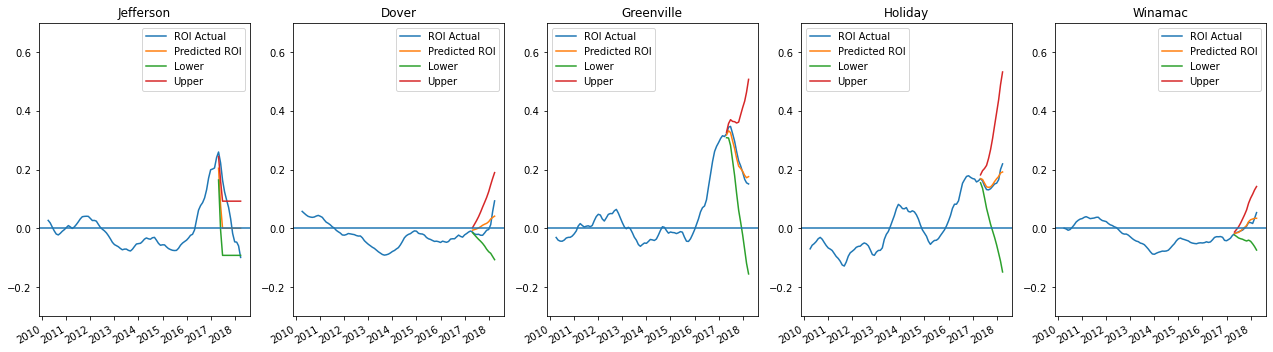

In [85]:
fig, axs = plt.subplots(1, 5, figsize=(22, 6))
for i, ax in enumerate(axs):
    ax.set_ylim(bottom=-0.3, top=0.7)
    ax.plot(results_list[i]['data']['2010-04-01':], label='ROI Actual')
    ax.plot(results_list[i]['predictions'].predicted_mean, label='Predicted ROI')
    ax.plot(results_list[i]['predictions'].conf_int(), label=['Lower', 'Upper'])
    ax.set_title(results_list[i]['city'])
    ax.axhline(y=0)
    ax.legend()
fig.autofmt_xdate()
plt.savefig('images/top_5_predictions_custom.png')

## Custom Model Forecasts

Now we'll look at the forecasts that each of these custom models makes for the 2018-2019 period.

In [86]:
forecasts_list = []
for zipcode, city in zip_dict_2.items():
    
    forecasts_dictionary={}
    
    zip_df = long_df_fast(melt_data(data[data['RegionName']==zipcode]))
    zip_us = zip_df-us
    zip_train = zip_us['2010-04-01':]['ROI']
    
    best_sarima = combs_dataframe.loc[:, ['comb', 'combs', zipcode]].sort_values(by=zipcode).head(1)
    
    sari_mod = SARIMAX(zip_train,
                                order=list(best_sarima.iloc[0])[0],
                                seasonal_order=list(best_sarima.iloc[0])[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
    preds = sari_mod.get_prediction(start='2018-05-01', end='2019-04-01', dynamic=True)
    
    forecasts_dictionary['city'] = city
    forecasts_dictionary['zipcode'] = zipcode
    forecasts_dictionary['predictions'] = preds
    forecasts_dictionary['data'] = zip_us['ROI']
    
    forecasts_list.append(forecasts_dictionary)

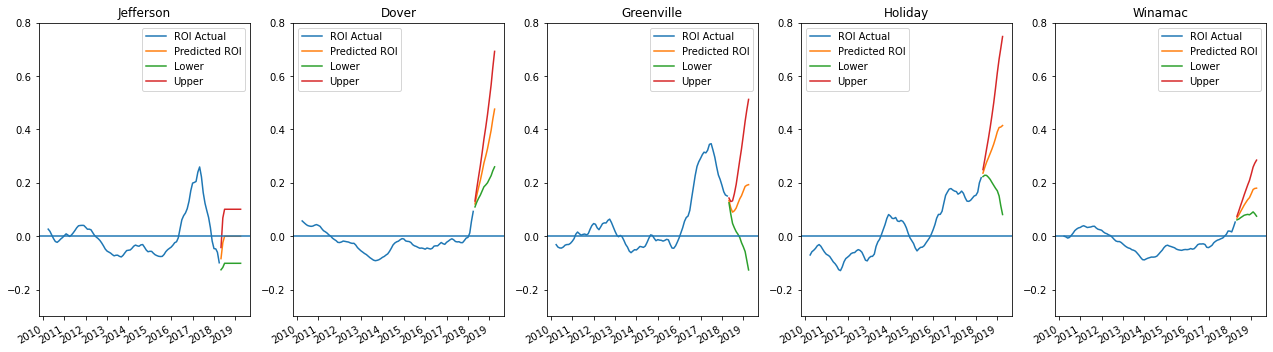

In [87]:
fig, axs = plt.subplots(1, 5, figsize=(22, 6))
for i, ax in enumerate(axs):
    ax.set_ylim(bottom=-0.3, top=0.8)
    ax.plot(forecasts_list[i]['data']['2010-04-01':], label='ROI Actual')
    ax.plot(forecasts_list[i]['predictions'].predicted_mean, label='Predicted ROI')
    ax.plot(forecasts_list[i]['predictions'].conf_int(), label=['Lower', 'Upper'])
    ax.set_title(forecasts_list[i]['city'])
    ax.axhline(y=0)
    ax.legend()
fig.autofmt_xdate()
plt.savefig('images/top_5_forecasts_custom.png')

For two of these zipcodes, Jefferson and Greenville, the lower interval became negative using the custom model after having been positive for the universal model. 

In [88]:
# forecasts for universal model

top_5_lower_interval

,zipcode,predicted mean,lower interval
6715,70121,0.333956,0.152095
8816,72837,0.273015,0.112034
6514,29601,0.252431,0.103501
3936,34691,0.256219,0.080849
9190,46996,0.188035,0.065623


In [89]:
# forecasts for custom model

custom_forecasts = [[n['zipcode'], n['predictions'].predicted_mean.loc['2019-04-01'], list(n['predictions'].conf_int().loc['2019-04-01',:])[0]] for n in forecasts_list]
forecasts_df = pd.DataFrame(custom_forecasts, columns=['zipcode', 'predicted mean', 'lower interval'])

forecasts_df

,zipcode,predicted mean,lower interval
0,70121,0.000000,-0.101179
1,72837,0.476173,0.260002
2,29601,0.193228,-0.126068
3,34691,0.414673,0.081393
4,46996,0.180164,0.075200


In [90]:
forecasts_df.set_index('zipcode', inplace=True)
top_5_lower_interval.set_index('zipcode', inplace=True)
forecasts_df['final mean'] = (forecasts_df['predicted mean'] + top_5_lower_interval['predicted mean'])/2
forecasts_df['final lower'] = (forecasts_df['lower interval'] + top_5_lower_interval['lower interval'])/2

In [91]:
# 'final mean' and 'final lower' average forecasts for the universal and custom models.
forecasts_df.sort_values(by='final lower', ascending=False)

,predicted mean,lower interval,final mean,final lower
zipcode,,,,
72837,0.476173,0.260002,0.374594,0.186018
34691,0.414673,0.081393,0.335446,0.081121
46996,0.180164,0.075200,0.184100,0.070412
70121,0.000000,-0.101179,0.166978,0.025458
29601,0.193228,-0.126068,0.222830,-0.011284


When we average out the predicted values from our universal model with the predicted values for each zipcode's custom model, our highest predicted values are for the Dover Arkansas 72837 zipcode, while the previous top zipcode, 70121, now has a much lower set of predictions.

In [92]:
# list of most 2018-4 prices for each zipcode

prices = data[data['RegionName'].isin(list(zip_dict_2))][['RegionName','City', 'State','2018-04']]

In [93]:
prices.set_index('RegionName', inplace=True)
prices.sort_values(by='RegionName', inplace=True)
prices

,City,State,2018-04
RegionName,,,
29601,Greenville,SC,261900
34691,Holiday,FL,104800
46996,Winamac,IN,90800
70121,Jefferson,LA,171100
72837,Dover,AR,112000


In [94]:
forecasts_df.sort_values(by='zipcode', inplace=True)

In [95]:
top_5_lower_interval.sort_values(by='zipcode', inplace=True)

## Comparing Models:

Below we compare price predictions of the universal model, the custom models and a model that averages out the predictions of both these models. The predictions below incorporate the 6.4% year over year increase in home prices that took place between Q2 of 2018 and Q2 of 2019.

https://www.attomdata.com/news/market-trends/q2-2019-u-s-home-sales-report/#:~:text=%E2%80%93%20July%2018%2C%202019%20%E2%80%94%20ATTOM,in%20the%20second%20quarter%2C%20up

In [96]:
#calculating forecast price information for each zipcode

prices['Forecasted Price 2019-04'] = round(prices['2018-04']*(1 + forecasts_df['final mean']+0.064))
prices['Forecasted Lower Interval 2019-04'] = round(prices['2018-04']*(1 + forecasts_df['final lower']+0.064))
prices['Forecasted Custom'] = round(prices['2018-04']*(1 + forecasts_df['predicted mean']+0.064))
prices['Forecasted Custom Lower'] = round(prices['2018-04']*(1 + forecasts_df['lower interval']+0.064))
prices['Forecasted Universal'] = round(prices['2018-04']*(1 + top_5_lower_interval['predicted mean']+0.064))
prices['Forecasted Universal Lower'] = round(prices['2018-04']*(1 + top_5_lower_interval['lower interval']+0.064))

In [97]:
prices

,City,State,2018-04,Forecasted Price 2019-04,Forecasted Lower Interval 2019-04,Forecasted Custom,Forecasted Custom Lower,Forecasted Universal,Forecasted Universal Lower
RegionName,,,,,,,,,
29601,Greenville,SC,261900,337021.0,275706.0,329268.0,245644.0,344773.0,305769.0
34691,Holiday,FL,104800,146662.0,120009.0,154965.0,120037.0,138359.0,119980.0
46996,Winamac,IN,90800,113327.0,103005.0,112970.0,103439.0,113685.0,102570.0
70121,Jefferson,LA,171100,210620.0,186406.0,182050.0,164739.0,239190.0,208074.0
72837,Dover,AR,112000,161123.0,140002.0,172499.0,148288.0,149746.0,131716.0


And below we can see the prices predicted by each of these models compared to May 2019 prices found on zillow.com. 

In [98]:
# actual median prices for april 2019

prices['actual'] = [319000, 113000, 107000, 216000, 122000]

In [99]:
prices_final = prices[['City', 'State','2018-04', 'Forecasted Universal', 'Forecasted Universal Lower']]

In [100]:
prices_final.rename(columns={'2018-04':'Median Price 2018-04','Forecasted Universal': 'Forecast 2019-04', 'Forecasted Universal Lower': 'Lower Interval 2019-04'})

,City,State,Median Price 2018-04,Forecast 2019-04,Lower Interval 2019-04
RegionName,,,,,
29601,Greenville,SC,261900,344773.0,305769.0
34691,Holiday,FL,104800,138359.0,119980.0
46996,Winamac,IN,90800,113685.0,102570.0
70121,Jefferson,LA,171100,239190.0,208074.0
72837,Dover,AR,112000,149746.0,131716.0


### RMSE for Combined Model, Universal Model and Custom Models

In [101]:
# RMSE averaging

np.sqrt(((prices['Forecasted Price 2019-04'] - prices['actual'])**2).sum())

55294.40426480785

In [102]:
# RMSE universal model

np.sqrt(((prices['Forecasted Universal'] - prices['actual'])**2).sum())

51571.62253604205

In [103]:
# RMSE custom models

np.sqrt(((prices['Forecasted Custom'] - prices['actual'])**2).sum())

74865.78290514299

Two zipcodes (Holiday, FL and Dover AR) fell short of our predictions regardless of the model we were using. 

However, we would have had the lowest RMSE in prices if we had accepted the predictions of the universal model rather than the custom models that were fit to specific zip codes. This suggests that the method of validating the universal model by testing it on a large number zipcodes ensured that it was highly generalizable and could make good predictions for a wide range of real estate markets.

## Recommendation

Given the superior performance of the (1, 1, 2)x(1, 0, 1, 12) SARIMA model in comparison with custom models, my recommendation is that the forecasts given by this model be used to determine the best zipcodes for real estate investment.

## Interpretation and Further Questions

One source of doubt about the universal model is that it was trained on a very specific set of zip codes (the top 5 by value, ROI etc.), so it's possible that different features would be selected from a random set of zipcodes. We could easily test this by picking out twenty random zip codes and seeing if a grid search yields a different set of SARIMA features.

It's also worth investigating whether there is a difference between zipcodes that have highly positive covariance with the US market, zipcodes that have highly negative covariance with the US market, and zipcodes that have low absolute covariance with the US market. Because these different zipcodes have a different place in the hierarchy of real estate goods, it seems plausible that their performance would follow different patterns and that we might be able to identify different SARIMA models for each category.